In [1]:
import json
import pandas as pd
import geopandas as gpd
import plotly.express as px
import plotly.io as pio
import numpy as np

import lightgbm as lgb
import matplotlib.pyplot as plt
import warnings
import pickle

/Users/ryan/miniforge3/envs/bayes6420/lib/python3.11/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


In [73]:
import os
os.environ["GEOPANDAS_IO_ENGINE"] = "fiona"

### Read in Data

In [74]:
df_ucd = pd.read_csv('/Users/ryan/OMSA/3.Fall2025/CSE6242/Project/data/WONDER_data(in).csv')
df_urban = pd.read_csv('/Users/ryan/OMSA/3.Fall2025/CSE6242/Project/data/urban_rural.csv')
df_states = pd.read_csv('/Users/ryan/OMSA/3.Fall2025/CSE6242/Project/data/WONDER_states_combined.csv')

## Final Submittal

In the process of completing the progress report, we identified some holes in our approach. As such, we've scaled back the submittal to 'State' data and then re-aggregated the dataset.

In this section I'll be working with the re-aggregated data 'df_states' and folding in new data that will inform the user interface

In [75]:
df_states.head(5)

Notes    Year    State  State Code Sex Code Ten-Year Age Groups Code  \
0   NaN  1999.0  Alabama         1.0        F                        1   
1   NaN  1999.0  Alabama         1.0        F                        1   
2   NaN  1999.0  Alabama         1.0        F                        1   
3   NaN  1999.0  Alabama         1.0        F                        1   
4   NaN  1999.0  Alabama         1.0        F                        1   

                               ICD-10 113 Cause List      Deaths  Population  
0                     #Malignant neoplasms (C00-C97)  Suppressed     28712.0  
1       #Diseases of heart (I00-I09,I11,I13,I20-I51)  Suppressed     28712.0  
2                #Cerebrovascular diseases (I60-I69)           0     28712.0  
3      #Chronic lower respiratory diseases (J40-J47)           0     28712.0  
4  #Accidents (unintentional injuries) (V01-X59,Y...  Suppressed     28712.0

In [76]:
df_states = df_states[~df_states['Year'].isna()]

In [77]:
df_states.isna().sum()

Notes                       100980
Year                             0
State                            0
State Code                       0
Sex Code                         0
Ten-Year Age Groups Code         0
ICD-10 113 Cause List            0
Deaths                           0
Population                       0
dtype: int64

In [78]:
df_states.drop(columns='Notes',inplace=True)

In [79]:
df_states

Year    State  State Code Sex Code Ten-Year Age Groups Code  \
0       1999.0  Alabama         1.0        F                        1   
1       1999.0  Alabama         1.0        F                        1   
2       1999.0  Alabama         1.0        F                        1   
3       1999.0  Alabama         1.0        F                        1   
4       1999.0  Alabama         1.0        F                        1   
...        ...      ...         ...      ...                      ...   
101477  2020.0  Wyoming        56.0        M                    65-74   
101478  2020.0  Wyoming        56.0        M                    65-74   
101479  2020.0  Wyoming        56.0        M                    65-74   
101480  2020.0  Wyoming        56.0        M                    65-74   
101481  2020.0  Wyoming        56.0        M                    65-74   

                                    ICD-10 113 Cause List      Deaths  \
0                          #Malignant neoplasms (C00-C97)  Suppressed   
1            #Diseases of heart (I00-I09,I11,I13,I20-I51)  Suppressed   
2                     #Cerebrovascular diseases (I60-I69)           0   
3           #Chronic lower respiratory diseases (J40-J47)           0   
4       #Accidents (unintentional injuries) (V01-X59,Y...  Suppressed   
...                                                   ...         ...   
101477                     #Malignant neoplasms (C00-C97)         188   
101478       #Diseases of heart (I00-I09,I11,I13,I20-I51)         186   
101479                #Cerebrovascular diseases (I60-I69)          21   
101480      #Chronic lower respiratory diseases (J40-J47)          64   
101481  #Accidents (unintentional injuries) (V01-X59,Y...          24   

        Population  
0          28712.0  
1          28712.0  
2          28712.0  
3          28712.0  
4          28712.0  
...            ...  
101477     32197.0  
101478     32197.0  
101479     32197.0  
101480     32197.0  
101481     32197.0  

[100980 rows x 8 columns]

In [80]:
df_states = df_states.rename(columns = {"Year":"year","State":"state","ICD-10 113 Cause List":"UCD","Ten-Year Age Groups Code":"age_code","Deaths":"deaths","Population":"population","Sex Code":"sex","State Code":"state_code"})

In [81]:
df_states

year    state  state_code sex age_code  \
0       1999.0  Alabama         1.0   F        1   
1       1999.0  Alabama         1.0   F        1   
2       1999.0  Alabama         1.0   F        1   
3       1999.0  Alabama         1.0   F        1   
4       1999.0  Alabama         1.0   F        1   
...        ...      ...         ...  ..      ...   
101477  2020.0  Wyoming        56.0   M    65-74   
101478  2020.0  Wyoming        56.0   M    65-74   
101479  2020.0  Wyoming        56.0   M    65-74   
101480  2020.0  Wyoming        56.0   M    65-74   
101481  2020.0  Wyoming        56.0   M    65-74   

                                                      UCD      deaths  \
0                          #Malignant neoplasms (C00-C97)  Suppressed   
1            #Diseases of heart (I00-I09,I11,I13,I20-I51)  Suppressed   
2                     #Cerebrovascular diseases (I60-I69)           0   
3           #Chronic lower respiratory diseases (J40-J47)           0   
4       #Accidents (unintentional injuries) (V01-X59,Y...  Suppressed   
...                                                   ...         ...   
101477                     #Malignant neoplasms (C00-C97)         188   
101478       #Diseases of heart (I00-I09,I11,I13,I20-I51)         186   
101479                #Cerebrovascular diseases (I60-I69)          21   
101480      #Chronic lower respiratory diseases (J40-J47)          64   
101481  #Accidents (unintentional injuries) (V01-X59,Y...          24   

        population  
0          28712.0  
1          28712.0  
2          28712.0  
3          28712.0  
4          28712.0  
...            ...  
101477     32197.0  
101478     32197.0  
101479     32197.0  
101480     32197.0  
101481     32197.0  

[100980 rows x 8 columns]

In [82]:
df_states['UCD'].unique()

array(['#Malignant neoplasms (C00-C97)',
       '#Diseases of heart (I00-I09,I11,I13,I20-I51)',
       '#Cerebrovascular diseases (I60-I69)',
       '#Chronic lower respiratory diseases (J40-J47)',
       '#Accidents (unintentional injuries) (V01-X59,Y85-Y86)'],
      dtype=object)

We can see that the UCD is limited to the top 5 causes of death over this timeframe. The goal of this model is to see how different scenarios may affect the overall death rates. To connect the UI to the data, we can use various societal metrics such as 'poverty rate', 'smoking rates',and 'obesity rates'.

Below I'll extract that data and fold it into the 'df_states' dataset above:

## Obesity Rate

For obesity rate we'll likely have to splice several datasets together. First, the CDC Surveillance dataset:

In [83]:
df_raw = pd.read_csv('/Users/ryan/OMSA/3.Fall2025/CSE6242/Project/data/obesity.csv')

In [84]:
df_raw['YearStart'].unique()

array([2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021,
       2022, 2023])

In [85]:
df_raw.columns

Index(['YearStart', 'YearEnd', 'LocationAbbr', 'LocationDesc', 'Datasource',
       'Class', 'Topic', 'Question', 'Data_Value_Unit', 'Data_Value_Type',
       'Data_Value', 'Data_Value_Alt', 'Data_Value_Footnote_Symbol',
       'Data_Value_Footnote', 'Low_Confidence_Limit', 'High_Confidence_Limit ',
       'Sample_Size', 'Total', 'Age(years)', 'Education', 'Sex', 'Income',
       'Race/Ethnicity', 'GeoLocation', 'ClassID', 'TopicID', 'QuestionID',
       'DataValueTypeID', 'LocationID', 'StratificationCategory1',
       'Stratification1', 'StratificationCategoryId1', 'StratificationID1'],
      dtype='object')

In [86]:
df_raw['Data_Value'].describe()

count    93505.000000
mean        31.849359
std         10.417933
min          0.900000
25%         24.900000
50%         31.700000
75%         37.500000
max         85.300000
Name: Data_Value, dtype: float64

In [87]:
df_obesity = df_raw[
    df_raw['Question'] == "Percent of adults aged 18 years and older who have obesity"
].copy()

In [88]:
overall = df_obesity[df_obesity['StratificationCategory1'] == 'Total'].copy()

Let's aggregate obesity rates for each year,state, Age(years), and Sex combination to give us a single obesity rate that we can fold into the states data.

In [89]:
df_obesity_state = overall[['YearStart', 'LocationDesc', 'Data_Value']].rename(
    columns={
        'YearStart': 'year',
        'LocationDesc': 'state',
        'Data_Value': 'obesity_pct'
    }
)

df_obesity_state['year'] = df_obesity_state['year'].astype(int)
df_states['year'] = df_states['year'].astype(int)

In [90]:
df_obesity_state[df_obesity_state['state']=='Alabama']

year    state  obesity_pct
27     2011  Alabama         32.0
10807  2012  Alabama         33.0
15427  2013  Alabama         32.4
26207  2014  Alabama         33.5
30827  2015  Alabama         35.6
41607  2016  Alabama         35.7
49307  2017  Alabama         36.3
60087  2018  Alabama         36.2
67787  2019  Alabama         36.1
78567  2020  Alabama         39.0
86267  2021  Alabama         39.9
90887  2022  Alabama         38.3
95507  2023  Alabama         39.2

and then we can pull individual years from the annual CDC BRFSS data, which provides yearly survey data:

This allows us to fill in 1999-2010, which was missing in the original CDC dataset:

In [91]:
base_dir = "/Users/ryan/OMSA/3.Fall2025/CSE6242/Project/data/Obesity"

years = range(1999, 2011)
all_state_prev = []

for year in years:
    yy = str(year)[-2:]
    fname = f"CDBRFS{yy}_{year}.XPT"
    path = os.path.join(base_dir, fname)
    
    if not os.path.exists(path):
        print(f"File missing for {year}: {path}")
        continue
    
    print(f"Processing {year} from {fname}")
    brfss = pd.read_sas(path, format="xport")
    
    bmi_cat_vars = ["_BMI4CAT", "_BMI3CAT", "_BMI2CAT"]
    bmi_cat_var = next((v for v in bmi_cat_vars if v in brfss.columns), None)
    
    bmi_var = None
    bmi_is_continuous = False
    
    if bmi_cat_var is not None:
        bmi_var = bmi_cat_var
        bmi_is_continuous = False
    else:
        cont_candidates = ["_BMI2", "_BMI"]
        cont_var = next((v for v in cont_candidates if v in brfss.columns), None)
        if cont_var is not None:
            bmi_var = cont_var
            bmi_is_continuous = True
    
    wt_candidates = ["_LLCPWT", "_FINALWT"]
    wt_var = next((v for v in wt_candidates if v in brfss.columns), None)
    
    if bmi_var is None or wt_var is None:
        print(f"  Skipping {year}: couldn't find BMI or weight variable "
              f"(bmi_var={bmi_var}, wt_var={wt_var})")
        continue
    
    df = brfss[["_STATE", bmi_var, wt_var]].copy()
    
    if bmi_is_continuous:
        df = df[df[bmi_var].between(100, 999)]
        df["obese"] = (df[bmi_var] >= 300).astype(int)
    else:
        df = df[df[bmi_var].isin([1.0, 2.0, 3.0])]
        df["obese"] = (df[bmi_var] == 3.0).astype(int)
    
    state_prev = (
        df
        .groupby("_STATE")
        .apply(lambda g: (g["obese"] * g[wt_var]).sum() / g[wt_var].sum())
        .reset_index(name="obesity_prev")
    )
    
    state_prev["year"] = year
    all_state_prev.append(state_prev)

state_prev_all = pd.concat(all_state_prev, ignore_index=True)

Processing 1999 from CDBRFS99_1999.XPT
Processing 2000 from CDBRFS00_2000.XPT
Processing 2001 from CDBRFS01_2001.XPT
Processing 2002 from CDBRFS02_2002.XPT
Processing 2003 from CDBRFS03_2003.XPT
Processing 2004 from CDBRFS04_2004.XPT
Processing 2005 from CDBRFS05_2005.XPT
Processing 2006 from CDBRFS06_2006.XPT
Processing 2007 from CDBRFS07_2007.XPT
Processing 2008 from CDBRFS08_2008.XPT
Processing 2009 from CDBRFS09_2009.XPT
Processing 2010 from CDBRFS10_2010.XPT


In [92]:
state_prev_all.head(5)

_STATE  obesity_prev  year
0     1.0      0.242607  1999
1     2.0      0.223383  1999
2     4.0      0.161434  1999
3     5.0      0.247132  1999
4     6.0      0.218923  1999

Now we need to clean 'state_prev_all' so that we can cleanly merge this into the original dataframe:

In [93]:
state_lookup = (
    df_states[["state_code", "state"]]
    .drop_duplicates()
)

state_lookup["state_code"] = state_lookup["state_code"].astype(float)
state_prev_all["_STATE"] = state_prev_all["_STATE"].astype(float)

In [94]:
state_prev_named = state_prev_all.merge(
    state_lookup,
    left_on="_STATE",
    right_on="state_code",
    how="left"
)

state_prev_named = state_prev_named[state_prev_named["state"].notna()]

anchors_brfss = (
    state_prev_named
    .assign(
        obesity_pct=lambda d: d["obesity_prev"] * 100
    )[["state", "year", "obesity_pct"]]
    .sort_values(["state", "year"])
)

anchors_brfss.head()

state  year  obesity_pct
0    Alabama  1999    24.260702
52   Alabama  2000    23.906768
104  Alabama  2001    24.462515
158  Alabama  2002    25.683797
212  Alabama  2003    28.385736

In [95]:
df_obesity_state["year"] = df_obesity_state["year"].astype(int)
anchors_brfss["year"] = anchors_brfss["year"].astype(int)

obesity_full = pd.concat(
    [anchors_brfss, df_obesity_state],
    ignore_index=True
)

obesity_full = (
    obesity_full
    .sort_values(["state", "year"])
    .drop_duplicates(["state", "year"], keep="last")
)

and now we can merge into df_states:

In [96]:
df_states["year"] = df_states["year"].astype(int)

df_states = df_states.merge(
    obesity_full,
    on=["state", "year"],
    how="left"
)

In [97]:
df_states.head(5)

year    state  state_code sex age_code  \
0  1999  Alabama         1.0   F        1   
1  1999  Alabama         1.0   F        1   
2  1999  Alabama         1.0   F        1   
3  1999  Alabama         1.0   F        1   
4  1999  Alabama         1.0   F        1   

                                                 UCD      deaths  population  \
0                     #Malignant neoplasms (C00-C97)  Suppressed     28712.0   
1       #Diseases of heart (I00-I09,I11,I13,I20-I51)  Suppressed     28712.0   
2                #Cerebrovascular diseases (I60-I69)           0     28712.0   
3      #Chronic lower respiratory diseases (J40-J47)           0     28712.0   
4  #Accidents (unintentional injuries) (V01-X59,Y...  Suppressed     28712.0   

   obesity_pct  
0    24.260702  
1    24.260702  
2    24.260702  
3    24.260702  
4    24.260702

In [98]:
if "obesity_pct_x" in df_states.columns and "obesity_pct_y" in df_states.columns:
    df_states["obesity_pct"] = df_states["obesity_pct_y"].fillna(df_states["obesity_pct_x"])
    df_states = df_states.drop(columns=["obesity_pct_x", "obesity_pct_y"])

Now let's check the data using a simple plot to make sure the obesity data makes sense:

In [99]:
df_states["year"] = df_states["year"].astype(int)
df_states["obesity_pct"] = pd.to_numeric(df_states["obesity_pct"], errors="coerce")

plot_df = (
    df_states[["state", "year", "obesity_pct"]]
    .dropna(subset=["obesity_pct"])
    .drop_duplicates()
    .sort_values(["state", "year"])
)

print(plot_df.head())

         state  year  obesity_pct
0      Alabama  1999    24.260702
4590   Alabama  2000    23.906768
9180   Alabama  2001    24.462515
13770  Alabama  2002    25.683797
18360  Alabama  2003    28.385736


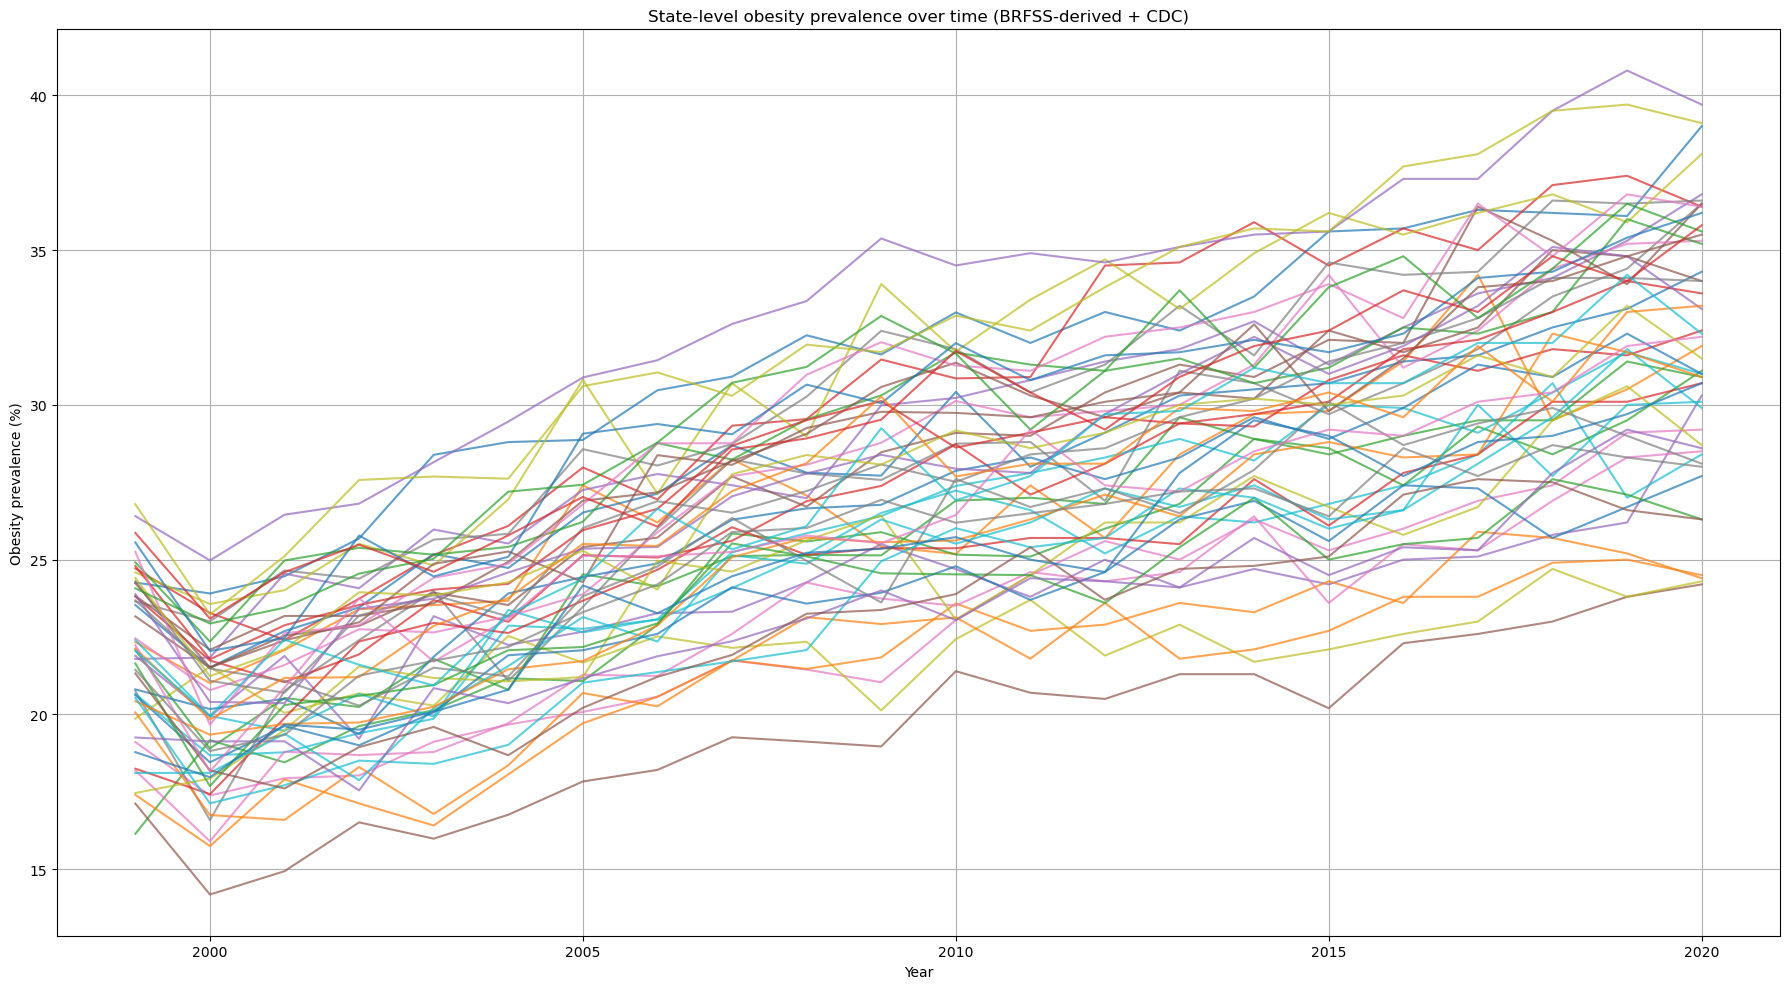

In [100]:
plt.figure(figsize=(18, 10))

for state, grp in plot_df.groupby("state"):
    plt.plot(grp["year"], grp["obesity_pct"], label=state, alpha=0.7)

plt.xlabel("Year")
plt.ylabel("Obesity prevalence (%)")
plt.title("State-level obesity prevalence over time (BRFSS-derived + CDC)")

plt.grid(True)
plt.tight_layout()
plt.show()

In [101]:
df_states['obesity_pct'].isna().sum()

np.int64(180)

In [102]:
df_states[(df_states['state']=='Hawaii')& (df_states['year']==2004)]

year   state  state_code sex age_code  \
23940  2004  Hawaii        15.0   F        1   
23941  2004  Hawaii        15.0   F        1   
23942  2004  Hawaii        15.0   F        1   
23943  2004  Hawaii        15.0   F        1   
23944  2004  Hawaii        15.0   F        1   
...     ...     ...         ...  ..      ...   
24025  2004  Hawaii        15.0   M    65-74   
24026  2004  Hawaii        15.0   M    65-74   
24027  2004  Hawaii        15.0   M    65-74   
24028  2004  Hawaii        15.0   M    65-74   
24029  2004  Hawaii        15.0   M    65-74   

                                                     UCD      deaths  \
23940                     #Malignant neoplasms (C00-C97)           0   
23941       #Diseases of heart (I00-I09,I11,I13,I20-I51)  Suppressed   
23942                #Cerebrovascular diseases (I60-I69)           0   
23943      #Chronic lower respiratory diseases (J40-J47)           0   
23944  #Accidents (unintentional injuries) (V01-X59,Y...  Suppressed   
...                                                  ...         ...   
24025                     #Malignant neoplasms (C00-C97)         289   
24026       #Diseases of heart (I00-I09,I11,I13,I20-I51)         263   
24027                #Cerebrovascular diseases (I60-I69)          37   
24028      #Chronic lower respiratory diseases (J40-J47)          35   
24029  #Accidents (unintentional injuries) (V01-X59,Y...          14   

       population  obesity_pct  
23940      8872.0          NaN  
23941      8872.0          NaN  
23942      8872.0          NaN  
23943      8872.0          NaN  
23944      8872.0          NaN  
...           ...          ...  
24025     38808.0          NaN  
24026     38808.0          NaN  
24027     38808.0          NaN  
24028     38808.0          NaN  
24029     38808.0          NaN  

[90 rows x 9 columns]

This tells us that the data are reasonable and that we correctly loaded in the data for each state.

### Smoking Rate, SeatBelt Usage Rate, and Alcohol Consumption

Since we've already extracted the data files from the CDC, we can also extract other datapoints that may also be useful. We'll repeat the same looping as above to extract these different rates for each State/Year combination

In [103]:
def pick_first(candidates, columns):
    for c in candidates:
        if c in columns:
            return c
    return None

In [104]:
base_dir = "/Users/ryan/OMSA/3.Fall2025/CSE6242/Project/data/Obesity"

warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    message="DataFrameGroupBy.apply operated on the grouping columns"
)

def pick_first(candidates, columns):
    for c in candidates:
        if c in columns:
            return c
    return None

def wavg(x, w):
    return (x * w).sum() / w.sum()

years = range(1999, 2021)
all_risk = []

for year in years:
    # ---------- pick file name ----------
    if year <= 2010:
        yy = str(year)[-2:]
        fname = f"CDBRFS{yy}_{year}.XPT"
    else:
        fname = f"LLCP{year}.XPT"
    
    path = os.path.join(base_dir, fname)
    if not os.path.exists(path):
        print(f"File missing for {year}: {path}")
        continue
    
    print(f"\nProcessing {year} from {fname}")
    brfss = pd.read_sas(path, format="xport")
    cols = brfss.columns
    
    # ---------- weight variable ----------
    wt_var = pick_first(["_LLCPWT", "_FINALWT"], cols)
    if wt_var is None:
        print(f"  Skipping {year}: no weight variable found")
        continue
    
    year_state = None
    
    # ------------------------------------------------------------------
    # 1) SMOKING: % current smokers
    # ------------------------------------------------------------------
    smoke_rf = pick_first(["_RFSMOK3", "_RFSMOK2"], cols)
    smoke_cat = pick_first(["_SMOKER3", "_SMOKER2"], cols)
    
    if smoke_rf is not None:
        df_sm = brfss[["_STATE", smoke_rf, wt_var]].copy()
        df_sm = df_sm[df_sm[smoke_rf].isin([1, 2])]
        df_sm["current_smoker"] = (df_sm[smoke_rf] == 2).astype(int)
        
        sm_state = (
            df_sm
            .groupby("_STATE", as_index=False)
            .apply(lambda g: pd.Series(
                {"smoking_pct": wavg(g["current_smoker"], g[wt_var])}
            ))
        )
    elif smoke_cat is not None:
        df_sm = brfss[["_STATE", smoke_cat, wt_var]].copy()
        df_sm = df_sm[df_sm[smoke_cat].isin([1, 2, 3, 4])]
        df_sm["current_smoker"] = df_sm[smoke_cat].isin([1, 2]).astype(int)
        
        sm_state = (
            df_sm
            .groupby("_STATE", as_index=False)
            .apply(lambda g: pd.Series(
                {"smoking_pct": wavg(g["current_smoker"], g[wt_var])}
            ))
        )
    else:
        print(f"  Smoking vars not found for {year}")
        sm_state = None
    
    # ------------------------------------------------------------------
    # 2) UNINSURED: % without health insurance
    # ------------------------------------------------------------------
    hcov = pick_first(["_HCVU651", "_HCVU65"], cols)
    hlthpln = pick_first(["HLTHPLN1", "HLTHPLAN", "HLTHPLN"], cols)
    
    if hcov is not None:
        df_ins = brfss[["_STATE", hcov, wt_var]].copy()
        df_ins = df_ins[df_ins[hcov].isin([1, 2])]
        df_ins["uninsured"] = (df_ins[hcov] == 2).astype(int)
        
        ins_state = (
            df_ins
            .groupby("_STATE", as_index=False)
            .apply(lambda g: pd.Series(
                {"uninsured_pct": wavg(g["uninsured"], g[wt_var])}
            ))
        )
    elif hlthpln is not None:
        df_ins = brfss[["_STATE", hlthpln, wt_var]].copy()
        df_ins = df_ins[df_ins[hlthpln].isin([1, 2])]
        df_ins["uninsured"] = (df_ins[hlthpln] == 2).astype(int)
        
        ins_state = (
            df_ins
            .groupby("_STATE", as_index=False)
            .apply(lambda g: pd.Series(
                {"uninsured_pct": wavg(g["uninsured"], g[wt_var])}
            ))
        )
    else:
        print(f"  Insurance vars not found for {year}")
        ins_state = None
    
    # ------------------------------------------------------------------
    # 3) SEATBELT: % always / nearly always wear seatbelt
    # ------------------------------------------------------------------
    seat_rf = pick_first(["_RFSEAT3", "_RFSEAT2"], cols)
    seat_raw = pick_first(["SEATBELT", "seatbelt"], cols)
    
    if seat_rf is not None:
        df_sb = brfss[["_STATE", seat_rf, wt_var]].copy()
        df_sb = df_sb[df_sb[seat_rf].isin([1, 2])]
        df_sb["seatbelt_always"] = (df_sb[seat_rf] == 1).astype(int)
        
        sb_state = (
            df_sb
            .groupby("_STATE", as_index=False)
            .apply(lambda g: pd.Series(
                {"seatbelt_always_pct": wavg(g["seatbelt_always"], g[wt_var])}
            ))
        )
    elif seat_raw is not None:
        df_sb = brfss[["_STATE", seat_raw, wt_var]].copy()
        df_sb = df_sb[df_sb[seat_raw].isin([1, 2, 3, 4, 5])]
        df_sb["seatbelt_always"] = df_sb[seat_raw].isin([1, 2]).astype(int)
        
        sb_state = (
            df_sb
            .groupby("_STATE", as_index=False)
            .apply(lambda g: pd.Series(
                {"seatbelt_always_pct": wavg(g["seatbelt_always"], g[wt_var])}
            ))
        )
    else:
        print(f"  Seatbelt vars not found for {year}")
        sb_state = None
    
    # ------------------------------------------------------------------
    # 4) ALCOHOL: % binge drinkers (based on _RFBING* family)
    # ------------------------------------------------------------------
    binge_var = pick_first(["_RFBING5", "_RFBING4", "_RFBING3", "_RFBING2"], cols)
    
    if binge_var is not None:
        df_alc = brfss[["_STATE", binge_var, wt_var]].copy()
        df_alc = df_alc[df_alc[binge_var].isin([1, 2])]
        df_alc["binge"] = (df_alc[binge_var] == 2).astype(int)
        
        alc_state = (
            df_alc
            .groupby("_STATE", as_index=False)
            .apply(lambda g: pd.Series(
                {"binge_drink_pct": wavg(g["binge"], g[wt_var])}
            ))
        )
    else:
        print(f"  Binge-drinking vars not found for {year}")
        alc_state = None

    # ------------------------------------------------------------------
    # 5) EDUCATION: mean EDUCA category (higher = more education)
    # ------------------------------------------------------------------
    educa_var = pick_first(["EDUCA", "EDUCA1", "_EDUCAG"], cols)
    if educa_var is not None:
        df_ed = brfss[["_STATE", educa_var, wt_var]].copy()
        df_ed = df_ed[df_ed[educa_var].between(1, 6, inclusive="both")]
        
        ed_state = (
            df_ed
            .groupby("_STATE", as_index=False)
            .apply(lambda g: pd.Series(
                {"educa_mean": wavg(g[educa_var], g[wt_var])}
            ))
        )
    else:
        print(f"  Education vars not found for {year}")
        ed_state = None

    # ------------------------------------------------------------------
    # 6) INCOME: mean INCOME2 category (higher = higher income)
    # ------------------------------------------------------------------
    income_var = pick_first(["INCOME2", "INCOME3", "INCOME"], cols)
    if income_var is not None:
        df_inc = brfss[["_STATE", income_var, wt_var]].copy()
        df_inc = df_inc[df_inc[income_var].between(1, 8, inclusive="both")]
        
        inc_state = (
            df_inc
            .groupby("_STATE", as_index=False)
            .apply(lambda g: pd.Series(
                {"income_mean": wavg(g[income_var], g[wt_var])}
            ))
        )
    else:
        print(f"  Income vars not found for {year}")
        inc_state = None

    # ------------------------------------------------------------------
    # 7) EMPLOYMENT: % employed (EMPLOY in {1,2})
    # ------------------------------------------------------------------
    employ_var = pick_first(["EMPLOY", "EMPLOY1"], cols)
    if employ_var is not None:
        df_emp = brfss[["_STATE", employ_var, wt_var]].copy()
        # keep valid codes 1–8
        df_emp = df_emp[df_emp[employ_var].between(1, 8, inclusive="both")]
        df_emp["employed"] = df_emp[employ_var].isin([1, 2]).astype(int)
        
        emp_state = (
            df_emp
            .groupby("_STATE", as_index=False)
            .apply(lambda g: pd.Series(
                {"employed_pct": wavg(g["employed"], g[wt_var])}
            ))
        )
    else:
        print(f"  Employment vars not found for {year}")
        emp_state = None

    # ------------------------------------------------------------------
    # 8) DIABETES: % ever told they have diabetes
    # ------------------------------------------------------------------
    diab_var = pick_first(["DIABETE3", "DIABETE2", "DIABETES", "_DIABDX"], cols)
    if diab_var is not None:
        df_db = brfss[["_STATE", diab_var, wt_var]].copy()
        df_db = df_db[df_db[diab_var].between(1, 4, inclusive="both")]
        df_db["diabetic"] = (df_db[diab_var] == 1).astype(int)
        
        diab_state = (
            df_db
            .groupby("_STATE", as_index=False)
            .apply(lambda g: pd.Series(
                {"diabetes_pct": wavg(g["diabetic"], g[wt_var])}
            ))
        )
    else:
        print(f"  Diabetes vars not found for {year}")
        diab_state = None
    
    # ------------------------------------------------------------------
    # Combine all metrics for this year on _STATE
    # ------------------------------------------------------------------
    for tmp in [
        sm_state, ins_state, sb_state, alc_state,
        ed_state, inc_state, emp_state, diab_state
    ]:
        if tmp is not None:
            if year_state is None:
                year_state = tmp.copy()
            else:
                year_state = year_state.merge(tmp, on="_STATE", how="outer")
    
    if year_state is None:
        print(f"  No usable risk-factor variables for {year}, skipping.")
        continue
    
    year_state["year"] = year
    all_risk.append(year_state)

risk_factors_all = pd.concat(all_risk, ignore_index=True)


Processing 1999 from CDBRFS99_1999.XPT
  Seatbelt vars not found for 1999
  Binge-drinking vars not found for 1999

Processing 2000 from CDBRFS00_2000.XPT
  Seatbelt vars not found for 2000
  Binge-drinking vars not found for 2000

Processing 2001 from CDBRFS01_2001.XPT
  Seatbelt vars not found for 2001
  Binge-drinking vars not found for 2001

Processing 2002 from CDBRFS02_2002.XPT

Processing 2003 from CDBRFS03_2003.XPT
  Seatbelt vars not found for 2003

Processing 2004 from CDBRFS04_2004.XPT
  Seatbelt vars not found for 2004

Processing 2005 from CDBRFS05_2005.XPT
  Seatbelt vars not found for 2005

Processing 2006 from CDBRFS06_2006.XPT

Processing 2007 from CDBRFS07_2007.XPT
  Seatbelt vars not found for 2007

Processing 2008 from CDBRFS08_2008.XPT

Processing 2009 from CDBRFS09_2009.XPT
  Seatbelt vars not found for 2009

Processing 2010 from CDBRFS10_2010.XPT

Processing 2011 from LLCP2011.XPT

Processing 2012 from LLCP2012.XPT

Processing 2013 from LLCP2013.XPT

Processing 

In [105]:
risk_factors_all

_STATE  smoking_pct  uninsured_pct  educa_mean  income_mean  \
0        1.0     0.234694       0.150660    4.409376     4.879943   
1        2.0     0.272825       0.232969    4.705128     5.679841   
2        4.0     0.200712       0.142224    4.584082     5.110911   
3        5.0     0.272312       0.160774    4.466023     4.931800   
4        6.0     0.187127       0.193270    4.536111     5.066535   
...      ...          ...            ...         ...          ...   
1165    54.0     0.225674       0.104747    4.501395     5.612085   
1166    55.0     0.154841       0.093421    4.771654     6.333777   
1167    56.0     0.184644       0.185358    4.786233     6.182715   
1168    66.0     0.200132       0.226103    4.406344     5.081950   
1169    72.0     0.099362       0.086529    4.442632     3.315266   

      employed_pct  diabetes_pct  year  seatbelt_always_pct  binge_drink_pct  
0         0.604900      0.073780  1999                  NaN              NaN  
1         0.699258      0.035266  1999                  NaN              NaN  
2         0.596994      0.042721  1999                  NaN              NaN  
3         0.594355      0.065878  1999                  NaN              NaN  
4         0.615767      0.060910  1999                  NaN              NaN  
...            ...           ...   ...                  ...              ...  
1165      0.487047           NaN  2020             0.835832         0.112308  
1166      0.577850           NaN  2020             0.861667         0.227583  
1167      0.611048           NaN  2020             0.766526         0.163504  
1168      0.535636           NaN  2020             0.880539         0.161913  
1169      0.443025           NaN  2020             0.939551         0.126916  

[1170 rows x 10 columns]

We were able to get the majority of the data, however 1999-2001 we don't have seatbelt data or binge drinking data. Since we have the majority of the 20 year period, we can impute the missing data:

In [106]:
rf = risk_factors_all.copy()
rf["year"] = rf["year"].astype(int)


impute_meta = {
    # "seatbelt_always_pct": (0.05, 0.99), 
    "binge_drink_pct": (0.01, 0.6),
    "employed_pct": (0.20, 0.90),
    "diabetes_pct": (0.00, 0.40),
    "educa_mean": (1.0, 6.0),
    "income_mean": (1.0, 8.0),
}

for var, (lo, hi) in impute_meta.items():
    if var not in rf.columns:
        continue
    
    rows = []
    
    for state, grp in rf.groupby("_STATE"):
        g = grp[["year", var]].dropna()
        if len(g) < 2:
            continue
        
        slope, intercept = np.polyfit(g["year"], g[var], deg=1)
        
        missing_years = grp.loc[grp[var].isna(), "year"].unique()
        if len(missing_years) == 0:
            continue
        
        for y in missing_years:
            pred = intercept + slope * y
            pred = max(lo, min(pred, hi))
            rows.append({"_STATE": state, "year": int(y), var: pred})
    
    if rows:
        fills = pd.DataFrame(rows)
        rf = rf.merge(fills, on=["_STATE", "year"], how="left", suffixes=("", "_fill"))
        rf[var] = rf[var].fillna(rf[f"{var}_fill"])
        rf = rf.drop(columns=[f"{var}_fill"])

In [ ]:
risk_factors_imputed = rf

rf = risk_factors_imputed.copy()
rf["year"] = rf["year"].astype(int)

var = "seatbelt_always_pct"
rows = []

for state, grp in rf.groupby("_STATE"):
    g = grp[["year", var]].drop_duplicates().sort_values("year")
    s = g.set_index("year")[var]

    if s.notna().sum() < 2:
        continue

    full_years = range(1999, 2021)
    s_full = s.reindex(full_years)

    s_interp = s_full.interpolate(method="linear", limit_area="inside")

    to_fill = s_full.isna() & s_interp.notna()
    for y, val in s_interp[to_fill].items():
        val_clamped = max(0.05, min(float(val), 0.99))
        rows.append({"_STATE": state, "year": int(y), var: val_clamped})

if rows:
    fills = pd.DataFrame(rows)
    rf = rf.merge(fills, on=["_STATE", "year"], how="left", suffixes=("", "_fill"))
    rf[var] = rf[var].fillna(rf[f"{var}_fill"])
    rf = rf.drop(columns=[f"{var}_fill"])

risk_factors_imputed = rf

In [107]:
risk_factors_imputed.isna().sum()

_STATE                   0
smoking_pct              0
uninsured_pct            0
educa_mean               0
income_mean              0
employed_pct             0
diabetes_pct             0
year                     0
seatbelt_always_pct    158
binge_drink_pct          0
dtype: int64

Now we can merge this into df_states like we did with Obesity:

In [108]:
df_states["year"] = df_states["year"].astype(int)
risk_factors_imputed["year"] = risk_factors_imputed["year"].astype(int)

state_lookup = (
    df_states[["state_code", "state"]]
    .drop_duplicates()
    .rename(columns={"state_code": "_STATE"})
)

rf_named = risk_factors_imputed.merge(state_lookup, on="_STATE", how="left")

missing_states = rf_named[rf_named["state"].isna()]["_STATE"].unique()
print("States with no name mapping:", missing_states)

pct_cols = [
    "smoking_pct",
    "uninsured_pct",
    "seatbelt_always_pct",
    "binge_drink_pct",
    "employed_pct",
    "diabetes_pct",
]

for col in pct_cols:
    if col in rf_named.columns:
        rf_named[col] = rf_named[col] * 100

cols_for_merge = [
    "state",
    "year",
    "smoking_pct",
    "uninsured_pct",
    "seatbelt_always_pct",
    "binge_drink_pct",
    "educa_mean",
    "income_mean",
    "employed_pct",
    "diabetes_pct",
]

rf_merge = rf_named[[c for c in cols_for_merge if c in rf_named.columns]]
df_states = df_states.merge(
    rf_merge,
    on=["state", "year"],
    how="left"
)

States with no name mapping: [72. 66. 78.]


In [109]:
cols_to_fix = [
    "obesity_pct",
    "smoking_pct",
    "uninsured_pct",
    "seatbelt_always_pct",
    "binge_drink_pct",
]

for base in cols_to_fix:
    col_x = f"{base}_x"
    col_y = f"{base}_y"
    
    has_x = col_x in df_states.columns
    has_y = col_y in df_states.columns
    
    if has_x and has_y:
        df_states[base] = df_states[col_y].fillna(df_states[col_x])
        df_states = df_states.drop(columns=[col_x, col_y])
    elif has_x:
        df_states[base] = df_states[col_x]
        df_states = df_states.drop(columns=[col_x])
    elif has_y:
        df_states[base] = df_states[col_y]
        df_states = df_states.drop(columns=[col_y])

df_states.isna().sum()

year                       0
state                      0
state_code                 0
sex                        0
age_code                   0
UCD                        0
deaths                     0
population                 0
obesity_pct              180
smoking_pct              180
uninsured_pct            180
seatbelt_always_pct    13950
binge_drink_pct          180
educa_mean               180
income_mean              180
employed_pct             180
diabetes_pct             180
dtype: int64

In [110]:
df_states.isna().sum()

year                       0
state                      0
state_code                 0
sex                        0
age_code                   0
UCD                        0
deaths                     0
population                 0
obesity_pct              180
smoking_pct              180
uninsured_pct            180
seatbelt_always_pct    13950
binge_drink_pct          180
educa_mean               180
income_mean              180
employed_pct             180
diabetes_pct             180
dtype: int64

In [111]:
pairs_states = df_states[["state", "year"]].drop_duplicates()
pairs_rf = rf_merge[["state", "year"]].drop_duplicates()

missing_pairs = (
    pairs_states
    .merge(pairs_rf, on=["state", "year"], how="left", indicator=True)
    .query('_merge == "left_only"')
    .drop(columns=["_merge"])
    .sort_values(["state", "year"])
)

missing_pairs

state  year
266       Hawaii  2004
1050  New Jersey  2019

The missing data we have is likely just due to individual states not reporting their data for that given year/condition. We'll have to interpolate these datapoints as this data likely doesn't exist.

In [112]:
vars_to_fill = [
    "smoking_pct",
    "uninsured_pct",
    "seatbelt_always_pct",
    "binge_drink_pct",
    "employed_pct",
    "diabetes_pct",
    "educa_mean",
    "income_mean",
]

impute_rows = []

for _, row in missing_pairs.iterrows():
    st = row["state"]
    yr = int(row["year"])
    
    imputed_vals = {"state": st, "year": yr}
    
    g_rf = rf_merge[rf_merge["state"] == st].copy().sort_values("year")
    
    for var in vars_to_fill:
        if var not in g_rf.columns:
            continue
        
        s = g_rf.set_index("year")[var].sort_index()
        full_years = range(int(g_rf["year"].min()), int(g_rf["year"].max()) + 1)
        full = s.reindex(full_years)
        filled = full.interpolate("linear", limit_direction="both")
        imputed_vals[var] = float(filled.loc[yr])
    
    g_ob = (
        df_states[df_states["state"] == st][["year", "obesity_pct"]]
        .dropna()
        .drop_duplicates()
        .sort_values("year")
    )
    
    if len(g_ob) >= 2:
        s_ob = g_ob.set_index("year")["obesity_pct"].sort_index()
        full_years_ob = range(int(g_ob["year"].min()), int(g_ob["year"].max()) + 1)
        full_ob = s_ob.reindex(full_years_ob)
        filled_ob = full_ob.interpolate("linear", limit_direction="both")
        imputed_vals["obesity_pct"] = float(filled_ob.loc[yr])
    else:
        imputed_vals["obesity_pct"] = np.nan
    
    impute_rows.append(imputed_vals)

imputed_df = pd.DataFrame(impute_rows)
imputed_df

state  year  smoking_pct  uninsured_pct  seatbelt_always_pct  \
0      Hawaii  2004    17.132477       7.989073            94.537927   
1  New Jersey  2019    11.942691      13.830956            90.627315   

   binge_drink_pct  employed_pct  diabetes_pct  educa_mean  income_mean  \
0        14.873470     64.722463      7.480892    4.918117     5.761944   
1        14.372527     57.799786     10.947937    4.806138     6.450621   

   obesity_pct  
0    18.063002  
1    26.700000

In [113]:
df_states = df_states.merge(
    imputed_df,
    on=["state", "year"],
    how="left",
    suffixes=("", "_imp")
)

for var in [
    "smoking_pct",
    "uninsured_pct",
    "seatbelt_always_pct",
    "binge_drink_pct",
    "employed_pct",
    "diabetes_pct",
    "educa_mean",
    "income_mean",
    "obesity_pct",
]:
    imp_col = f"{var}_imp"
    if imp_col in df_states.columns:
        df_states[var] = df_states[var].fillna(df_states[imp_col])
        df_states = df_states.drop(columns=[imp_col])

In [114]:
df_states.isna().sum()

year                       0
state                      0
state_code                 0
sex                        0
age_code                   0
UCD                        0
deaths                     0
population                 0
obesity_pct                0
smoking_pct                0
uninsured_pct              0
seatbelt_always_pct    13770
binge_drink_pct            0
educa_mean                 0
income_mean                0
employed_pct               0
diabetes_pct               0
dtype: int64

In [115]:
df_states

year    state  state_code sex age_code  \
0       1999  Alabama         1.0   F        1   
1       1999  Alabama         1.0   F        1   
2       1999  Alabama         1.0   F        1   
3       1999  Alabama         1.0   F        1   
4       1999  Alabama         1.0   F        1   
...      ...      ...         ...  ..      ...   
100975  2020  Wyoming        56.0   M    65-74   
100976  2020  Wyoming        56.0   M    65-74   
100977  2020  Wyoming        56.0   M    65-74   
100978  2020  Wyoming        56.0   M    65-74   
100979  2020  Wyoming        56.0   M    65-74   

                                                      UCD      deaths  \
0                          #Malignant neoplasms (C00-C97)  Suppressed   
1            #Diseases of heart (I00-I09,I11,I13,I20-I51)  Suppressed   
2                     #Cerebrovascular diseases (I60-I69)           0   
3           #Chronic lower respiratory diseases (J40-J47)           0   
4       #Accidents (unintentional injuries) (V01-X59,Y...  Suppressed   
...                                                   ...         ...   
100975                     #Malignant neoplasms (C00-C97)         188   
100976       #Diseases of heart (I00-I09,I11,I13,I20-I51)         186   
100977                #Cerebrovascular diseases (I60-I69)          21   
100978      #Chronic lower respiratory diseases (J40-J47)          64   
100979  #Accidents (unintentional injuries) (V01-X59,Y...          24   

        population  obesity_pct  smoking_pct  uninsured_pct  \
0          28712.0    24.260702    23.469362      15.065966   
1          28712.0    24.260702    23.469362      15.065966   
2          28712.0    24.260702    23.469362      15.065966   
3          28712.0    24.260702    23.469362      15.065966   
4          28712.0    24.260702    23.469362      15.065966   
...            ...          ...          ...            ...   
100975     32197.0    30.700000    18.464364      18.535808   
100976     32197.0    30.700000    18.464364      18.535808   
100977     32197.0    30.700000    18.464364      18.535808   
100978     32197.0    30.700000    18.464364      18.535808   
100979     32197.0    30.700000    18.464364      18.535808   

        seatbelt_always_pct  binge_drink_pct  educa_mean  income_mean  \
0                       NaN        11.681603    4.409376     4.879943   
1                       NaN        11.681603    4.409376     4.879943   
2                       NaN        11.681603    4.409376     4.879943   
3                       NaN        11.681603    4.409376     4.879943   
4                       NaN        11.681603    4.409376     4.879943   
...                     ...              ...         ...          ...   
100975            76.652623        16.350398    4.786233     6.182715   
100976            76.652623        16.350398    4.786233     6.182715   
100977            76.652623        16.350398    4.786233     6.182715   
100978            76.652623        16.350398    4.786233     6.182715   
100979            76.652623        16.350398    4.786233     6.182715   

        employed_pct  diabetes_pct  
0          60.490041      7.377977  
1          60.490041      7.377977  
2          60.490041      7.377977  
3          60.490041      7.377977  
4          60.490041      7.377977  
...              ...           ...  
100975     61.104818      9.855920  
100976     61.104818      9.855920  
100977     61.104818      9.855920  
100978     61.104818      9.855920  
100979     61.104818      9.855920  

[100980 rows x 17 columns]

In [116]:
df_states['income_mean'].describe()

count    100980.000000
mean          5.743159
std           0.387358
min           4.540197
25%           5.461534
50%           5.752906
75%           6.034989
max           6.647992
Name: income_mean, dtype: float64

#### Feature Validation

         state  year  educa_mean
0      Alabama  1999    4.409376
4590   Alabama  2000    4.495301
9180   Alabama  2001    4.495720
13770  Alabama  2002    4.526183
18360  Alabama  2003    4.561924


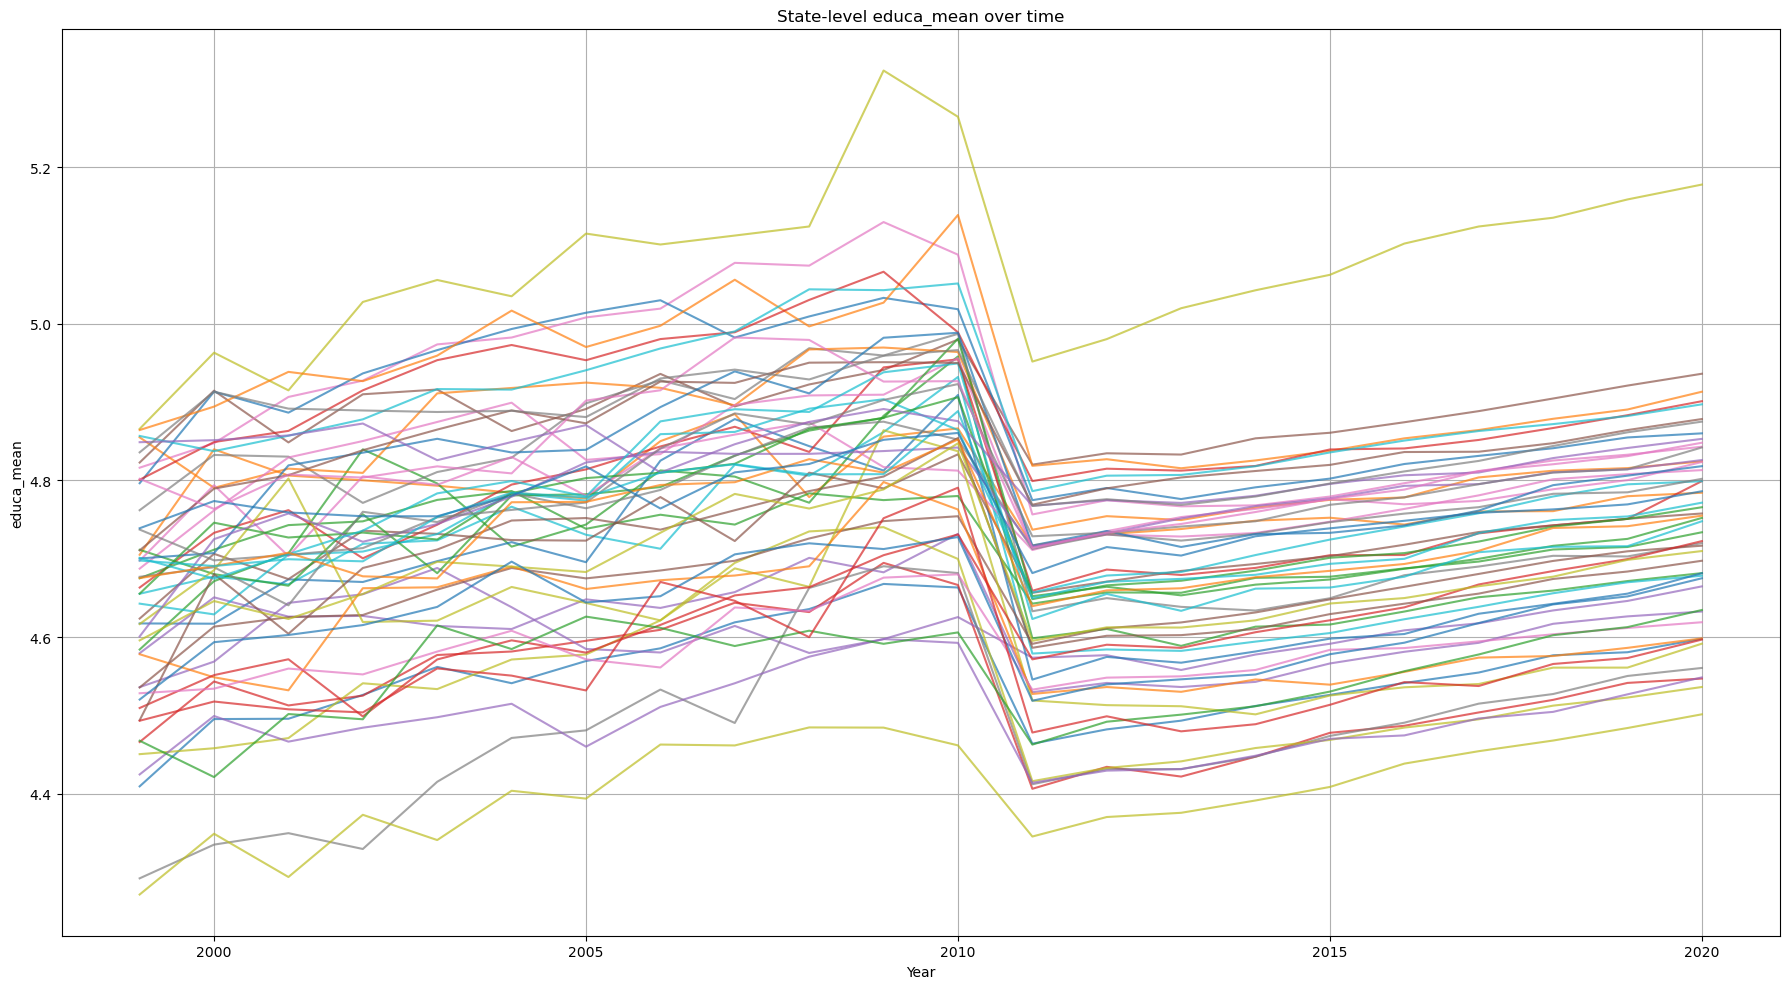

In [117]:
plot_field = "educa_mean"

df_states["year"] = df_states["year"].astype(int)
df_states[plot_field] = pd.to_numeric(df_states[plot_field], errors="coerce")

plot_df = (
    df_states[["state", "year", plot_field]]
    .dropna(subset=[plot_field])
    .drop_duplicates()
    .sort_values(["state", "year"])
)

print(plot_df.head())

plt.figure(figsize=(18, 10))

for state, grp in plot_df.groupby("state"):
    plt.plot(grp["year"], grp[plot_field], label=state, alpha=0.7)

plt.xlabel("Year")
plt.ylabel(plot_field)
plt.title(f"State-level {plot_field} over time")

plt.grid(True)
plt.tight_layout()
plt.show()

We can see a steep decline in 2010 that indicates that there's an error in how we're handling the Education means.

In [118]:
base_dir = "/Users/ryan/OMSA/3.Fall2025/CSE6242/Project/data/Obesity"
years = range(1999, 2021)

educa_log = []

for year in years:
    if year <= 2010:
        yy = str(year)[-2:]
        fname = f"CDBRFS{yy}_{year}.XPT"
    else:
        fname = f"LLCP{year}.XPT"
    
    path = os.path.join(base_dir, fname)
    if not os.path.exists(path):
        print(f"File missing for {year}: {path}")
        continue
    
    brfss = pd.read_sas(path, format="xport")
    cols = set(brfss.columns)
    
    present = [v for v in ["EDUCA", "EDUCA1", "_EDUCAG"] if v in cols]
    educa_log.append({"year": year, "present": present})
    print(year, present)

educa_log_df = pd.DataFrame(educa_log)

1999 ['EDUCA']
2000 ['EDUCA']
2001 ['EDUCA']
2002 ['EDUCA']
2003 ['EDUCA', '_EDUCAG']
2004 ['EDUCA', '_EDUCAG']
2005 ['EDUCA', '_EDUCAG']
2006 ['EDUCA', '_EDUCAG']
2007 ['EDUCA', '_EDUCAG']
2008 ['EDUCA', '_EDUCAG']
2009 ['EDUCA', '_EDUCAG']
2010 ['EDUCA', '_EDUCAG']
2011 ['EDUCA', '_EDUCAG']
2012 ['EDUCA', '_EDUCAG']
2013 ['EDUCA', '_EDUCAG']
2014 ['EDUCA', '_EDUCAG']
2015 ['EDUCA', '_EDUCAG']
2016 ['EDUCA', '_EDUCAG']
2017 ['EDUCA', '_EDUCAG']
2018 ['EDUCA', '_EDUCAG']
2019 ['EDUCA', '_EDUCAG']
2020 ['EDUCA', '_EDUCAG']


The problem we're having is that the methodaology used to obtain 'EDUCA' changes in 2010 which causes a disturbance in the general trend. To fix this, we can first center the data and then standardize it by the standard deviation of all education data each year:

In [119]:
df_states["educa_centered"] = (
    df_states["educa_mean"] - 
    df_states.groupby("year")["educa_mean"].transform("mean")
)

df_states["educa_z"] = (
    df_states["educa_mean"] - 
    df_states.groupby("year")["educa_mean"].transform("mean")
) / df_states.groupby("year")["educa_mean"].transform("std")

         state  year   educa_z
0      Alabama  1999 -1.626172
4590   Alabama  2000 -1.331668
9180   Alabama  2001 -1.365396
13770  Alabama  2002 -1.261013
18360  Alabama  2003 -1.194464


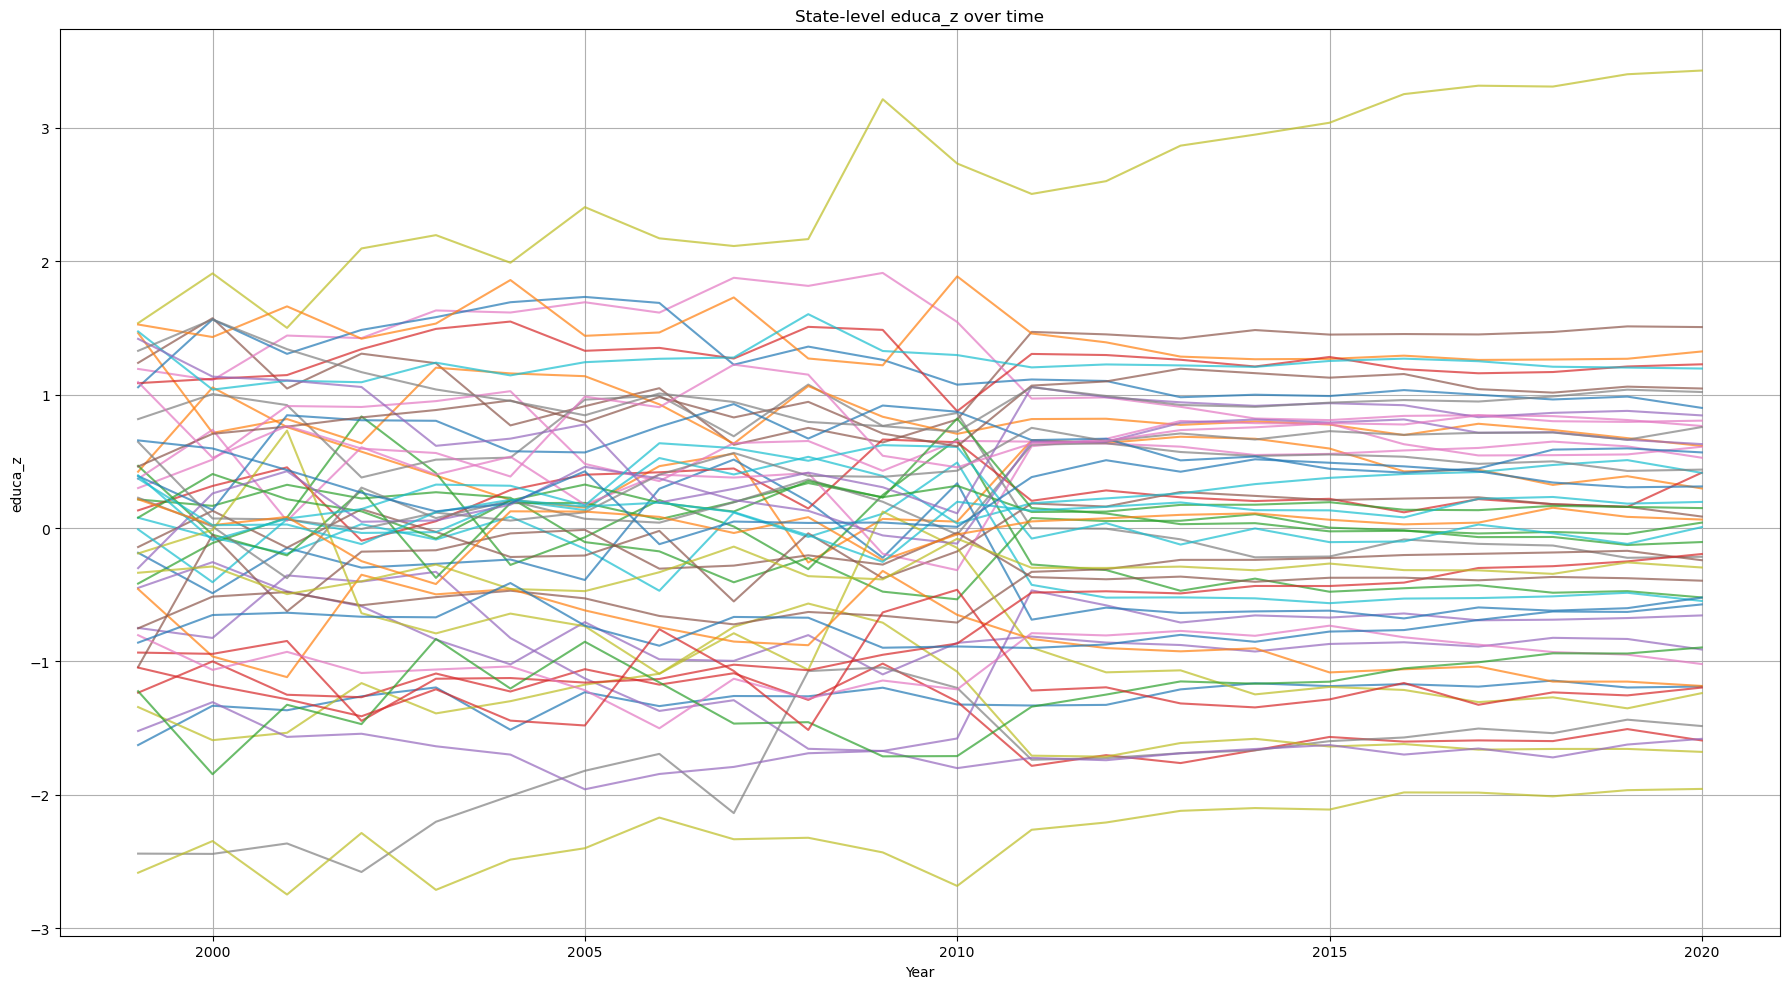

In [120]:
plot_field = "educa_z"

df_states["year"] = df_states["year"].astype(int)
df_states[plot_field] = pd.to_numeric(df_states[plot_field], errors="coerce")

plot_df = (
    df_states[["state", "year", plot_field]]
    .dropna(subset=[plot_field])
    .drop_duplicates()
    .sort_values(["state", "year"])
)

print(plot_df.head())

plt.figure(figsize=(18, 10))

for state, grp in plot_df.groupby("state"):
    plt.plot(grp["year"], grp[plot_field], label=state, alpha=0.7)

plt.xlabel("Year")
plt.ylabel(plot_field)
plt.title(f"State-level {plot_field} over time")

plt.grid(True)
plt.tight_layout()
plt.show()

This problem is also apparent in 'smoking_pct' and in 'binge_drink_pct', as all are qualitative surveys completed over the phone and the phone methodology is what changed in 2010:

         state  year  smoking_pct
0      Alabama  1999    23.469362
4590   Alabama  2000    25.244544
9180   Alabama  2001    23.815057
13770  Alabama  2002    24.364852
18360  Alabama  2003    25.335834


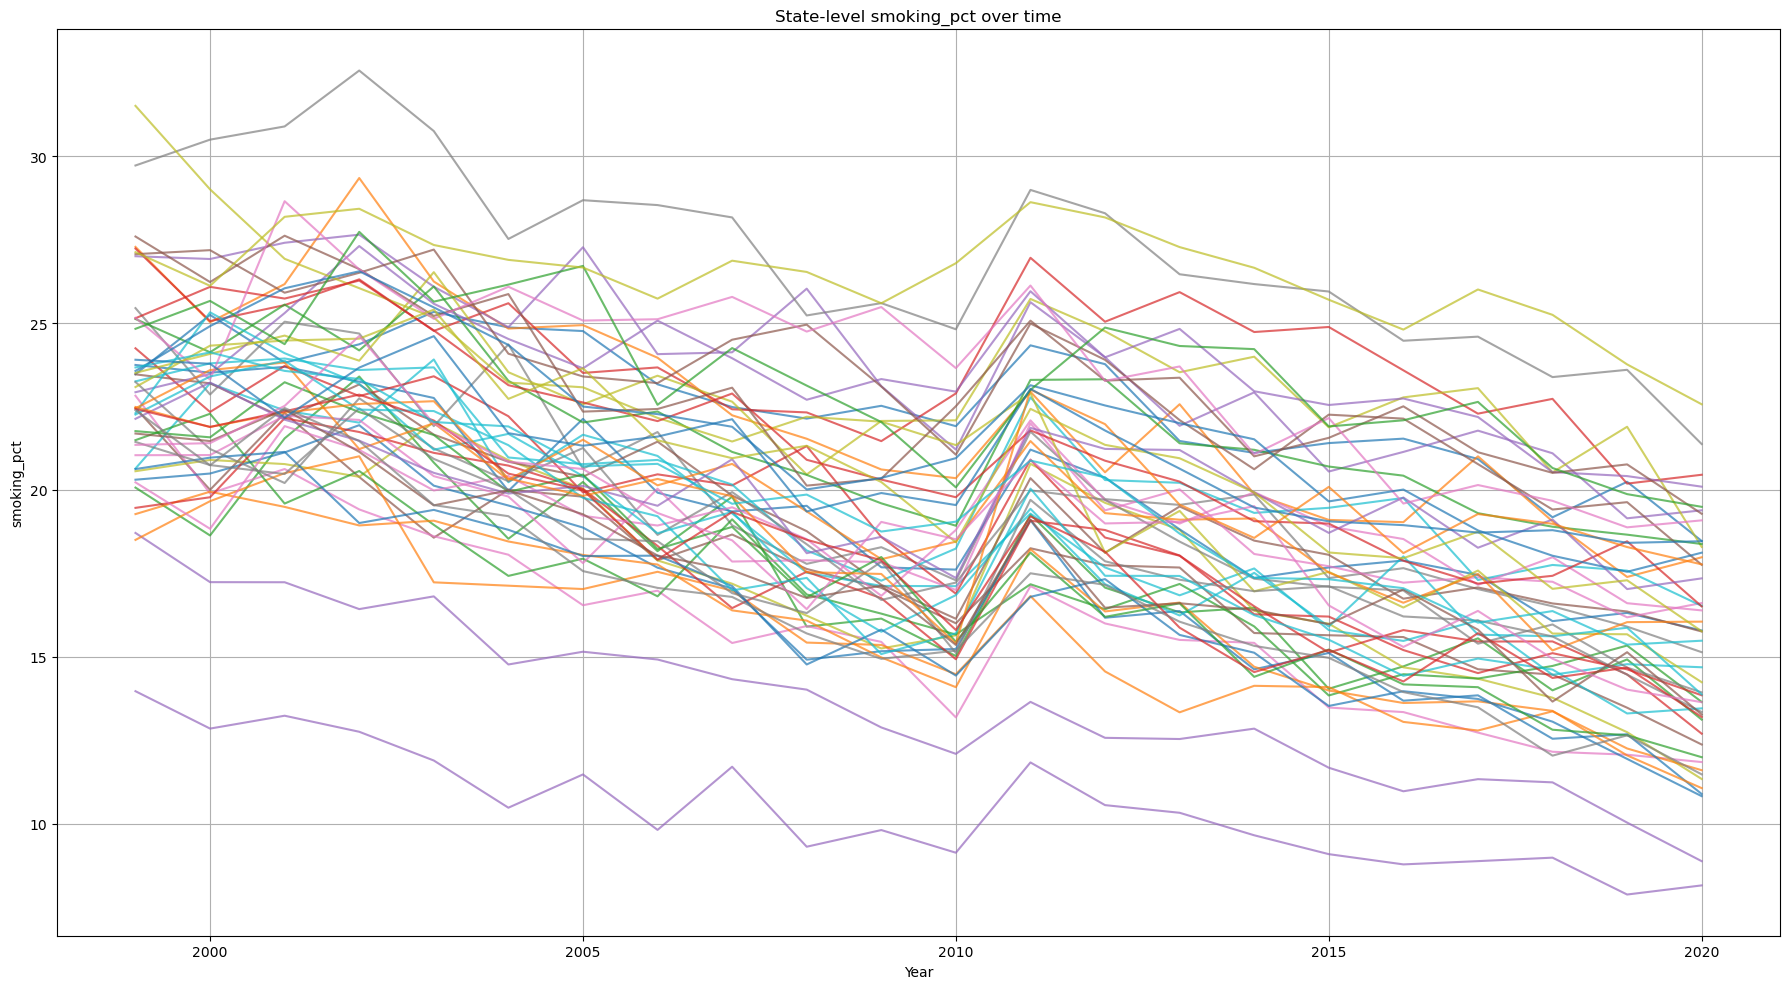

In [121]:
plot_field = "smoking_pct"

df_states["year"] = df_states["year"].astype(int)
df_states[plot_field] = pd.to_numeric(df_states[plot_field], errors="coerce")

plot_df = (
    df_states[["state", "year", plot_field]]
    .dropna(subset=[plot_field])
    .drop_duplicates()
    .sort_values(["state", "year"])
)

print(plot_df.head())

plt.figure(figsize=(18, 10))

for state, grp in plot_df.groupby("state"):
    plt.plot(grp["year"], grp[plot_field], label=state, alpha=0.7)

plt.xlabel("Year")
plt.ylabel(plot_field)
plt.title(f"State-level {plot_field} over time")

plt.grid(True)
plt.tight_layout()
plt.show()

In [122]:
df_states["year"] = df_states["year"].astype(int)

df_states["smoking_centered"] = (
    df_states["smoking_pct"]
    - df_states.groupby("year")["smoking_pct"].transform("mean")
)

df_states["smoking_z"] = (
    df_states["smoking_centered"]
    / df_states.groupby("year")["smoking_pct"].transform("std")
)

df_states["binge_centered"] = (
    df_states["binge_drink_pct"]
    - df_states.groupby("year")["binge_drink_pct"].transform("mean")
)

df_states["binge_z"] = (
    df_states["binge_centered"]
    / df_states.groupby("year")["binge_drink_pct"].transform("std")
)

In [123]:
for var in ["smoking_pct", "binge_drink_pct", "seatbelt_always_pct"]:
    centered = f"{var}_centered"
    zvar     = f"{var}_z"

    df_states[centered] = (
        df_states[var]
        - df_states.groupby("year")[var].transform("mean")
    )

    df_states[zvar] = (
        df_states[centered]
        / df_states.groupby("year")[var].transform("std")
    )

         state  year  smoking_pct_z
0      Alabama  1999       0.142507
4590   Alabama  2000       0.816940
9180   Alabama  2001       0.179415
13770  Alabama  2002       0.318778
18360  Alabama  2003       0.869258


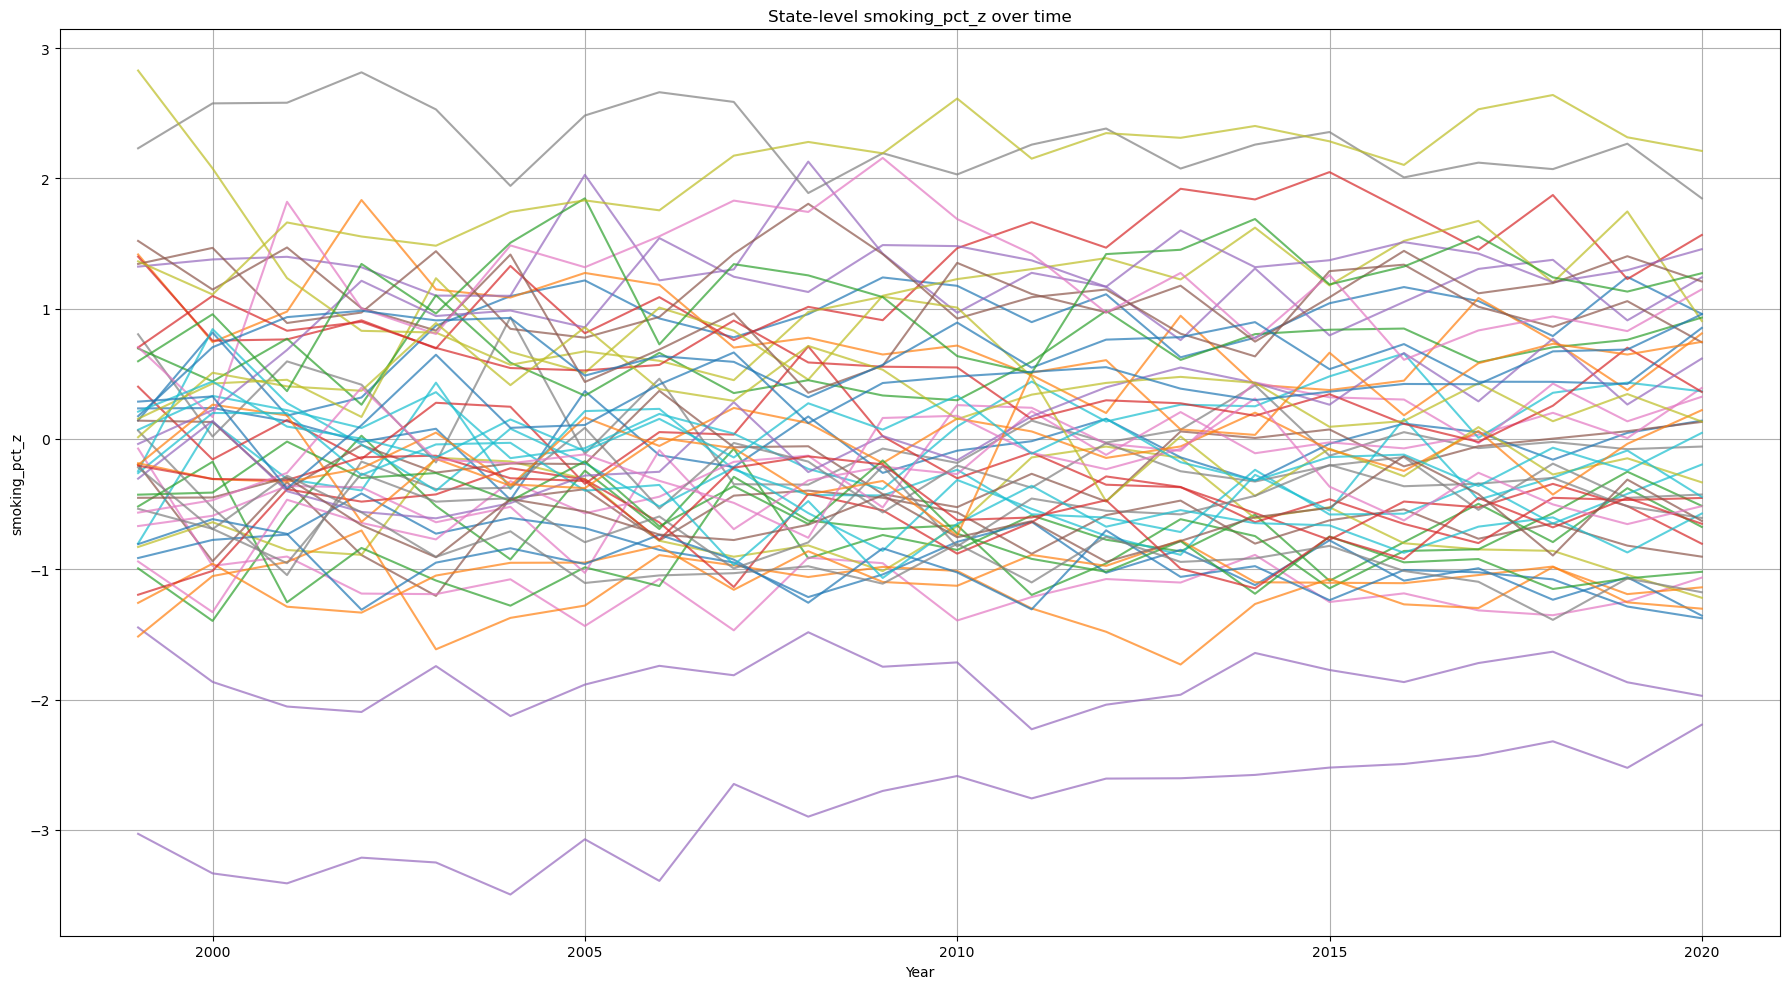

In [124]:
plot_field = "smoking_pct_z"

df_states["year"] = df_states["year"].astype(int)
df_states[plot_field] = pd.to_numeric(df_states[plot_field], errors="coerce")

plot_df = (
    df_states[["state", "year", plot_field]]
    .dropna(subset=[plot_field])
    .drop_duplicates()
    .sort_values(["state", "year"])
)

print(plot_df.head())

plt.figure(figsize=(18, 10))

for state, grp in plot_df.groupby("state"):
    plt.plot(grp["year"], grp[plot_field], label=state, alpha=0.7)

plt.xlabel("Year")
plt.ylabel(plot_field)
plt.title(f"State-level {plot_field} over time")

plt.grid(True)
plt.tight_layout()
plt.show()

This process has normalized the differences between methodologies, which should be beneficial for our model.

         state  year  seatbelt_always_pct_z
13770  Alabama  2002               1.105367
18360  Alabama  2003               0.877494
22950  Alabama  2004               0.687225
27540  Alabama  2005               0.531837
32130  Alabama  2006               0.405333


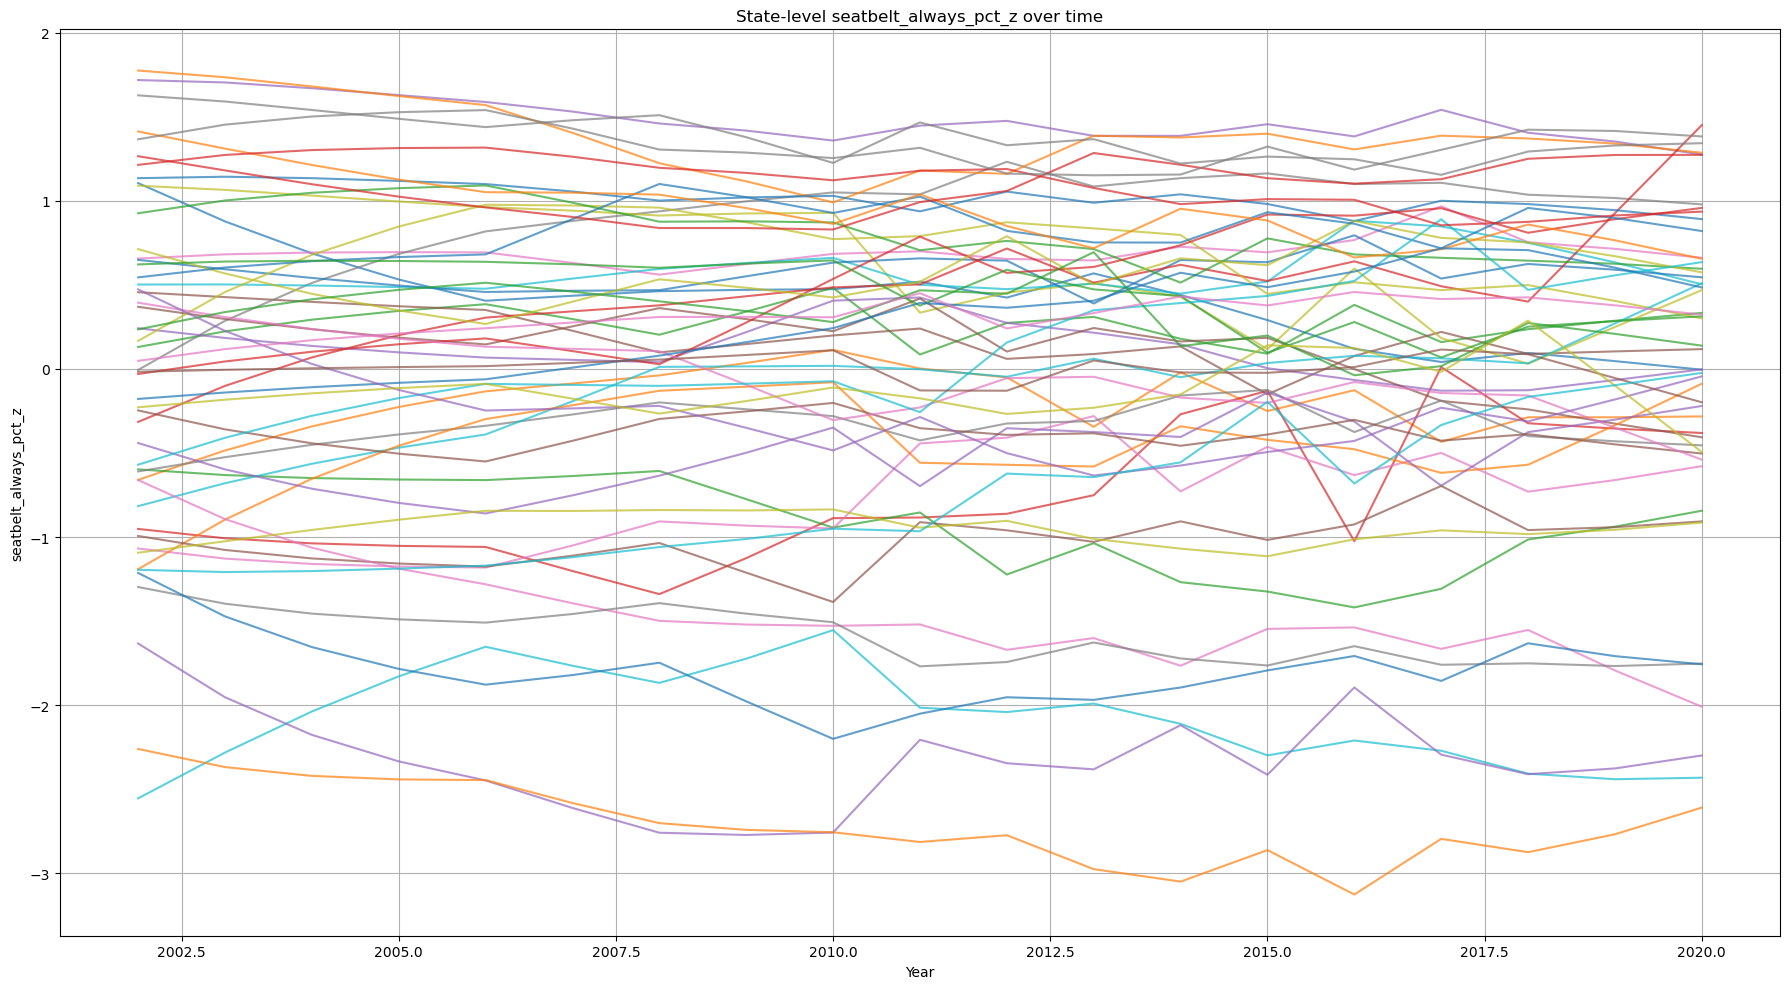

In [125]:
plot_field = "seatbelt_always_pct_z"

df_states["year"] = df_states["year"].astype(int)
df_states[plot_field] = pd.to_numeric(df_states[plot_field], errors="coerce")

plot_df = (
    df_states[["state", "year", plot_field]]
    .dropna(subset=[plot_field])
    .drop_duplicates()
    .sort_values(["state", "year"])
)

print(plot_df.head())

plt.figure(figsize=(18, 10))

for state, grp in plot_df.groupby("state"):
    plt.plot(grp["year"], grp[plot_field], label=state, alpha=0.7)

plt.xlabel("Year")
plt.ylabel(plot_field)
plt.title(f"State-level {plot_field} over time")

plt.grid(True)
plt.tight_layout()
plt.show()

In [126]:
cols_to_drop = [
    "educa_mean",
    "educa_centered",
    "smoking_pct",
    "smoking_centered",
    "smoking_z",
    "smoking_pct_centered",
    "binge_drink_pct",
    "binge_centered",
    "binge_z",
    "binge_drink_pct_centered",
    "seatbelt_always_pct",
    "seatbelt_always_pct_centered",
]

df_states = df_states.drop(columns=cols_to_drop)

### Percentage of Population in Rural Areas

Let's grab the Census data for each state that includes what percetange of the population lives in a rural area. I'll use:

https://www.census.gov/programs-surveys/geography/guidance/geo-areas/urban-rural.html

In [127]:
path_hist = "/Users/ryan/OMSA/3.Fall2025/CSE6242/Project/data/rural/pop-urban-pct-historical.csv"
hist = pd.read_csv(path_hist)

In [128]:
hist.head(5)

Area Name  2000  2010
0     Alabama  55.4  59.0
1      Alaska  65.6  66.0
2     Arizona  88.2  89.8
3    Arkansas  52.5  56.2
4  California  94.4  95.0

In [129]:
hist = hist[hist["Area Name"].notna()].copy()

hist = hist.rename(columns={
    "Area Name": "state",
    "2000": "urban_2000",
    "2010": "urban_2010"
})

hist["urban_2000"] = pd.to_numeric(hist["urban_2000"], errors="coerce")
hist["urban_2010"] = pd.to_numeric(hist["urban_2010"], errors="coerce")

rural_2000 = hist[["state", "urban_2000"]].copy()
rural_2000["rural_pct"] = 100 - rural_2000["urban_2000"]
rural_2000["year"] = 2000
rural_2000 = rural_2000[["state", "year", "rural_pct"]]

rural_2010_hist = hist[["state", "urban_2010"]].copy()
rural_2010_hist["rural_pct"] = 100 - rural_2010_hist["urban_2010"]
rural_2010_hist["year"] = 2010
rural_2010_hist = rural_2010_hist[["state", "year", "rural_pct"]]

In [130]:
path_cens = "/Users/ryan/OMSA/3.Fall2025/CSE6242/Project/data/rural/census_rural_2020_2010.csv"

cens = pd.read_csv(path_cens)
cens = cens[cens["STATE NAME"].notna()].copy()
cens = cens.rename(columns={
    "STATE NAME": "state",
    "2010 PCT RURAL POP": "rural_2010",
    "2020 PCT RURAL POP": "rural_2020",
})

rural_2010_cens = cens[["state", "rural_2010"]].copy()
rural_2010_cens["year"] = 2010
rural_2010_cens = rural_2010_cens.rename(columns={"rural_2010": "rural_pct"})

rural_2020 = cens[["state", "rural_2020"]].copy()
rural_2020["year"] = 2020
rural_2020 = rural_2020.rename(columns={"rural_2020": "rural_pct"})

In [131]:
rural_anchors = pd.concat(
    [rural_2000, rural_2010_cens, rural_2020],
    ignore_index=True
)

rural_anchors.sort_values(["state", "year"]).head()

state  year  rural_pct
0    Alabama  2000       44.6
51   Alabama  2010       41.0
107  Alabama  2020       42.3
1     Alaska  2000       34.4
52    Alaska  2010       34.0

In [132]:
rows = []

for state, grp in rural_anchors.groupby("state"):
    g = grp[["year", "rural_pct"]].dropna().drop_duplicates().sort_values("year")
    
    if len(g) == 0:
        continue
    
    years_full = np.arange(1999, 2021)
    s = g.set_index("year")["rural_pct"]
    s_full = s.reindex(years_full)
    
    s_interp = s_full.interpolate(method="linear", limit_direction="both")
    
    for y, val in s_interp.items():
        rows.append({"state": state, "year": int(y), "rural_pct": float(val)})

rural_full = pd.DataFrame(rows)

rural_full["rural_pct"] = rural_full["rural_pct"].clip(0, 100)

rural_full.sort_values(["state", "year"]).head()

state  year  rural_pct
0  Alabama  1999      44.60
1  Alabama  2000      44.60
2  Alabama  2001      44.24
3  Alabama  2002      43.88
4  Alabama  2003      43.52

In [133]:
df_states["year"] = df_states["year"].astype(int)

df_states = df_states.merge(
    rural_full,
    on=["state", "year"],
    how="left"
)

df_states[["state", "year", "rural_pct"]].head()

state  year  rural_pct
0  Alabama  1999       44.6
1  Alabama  1999       44.6
2  Alabama  1999       44.6
3  Alabama  1999       44.6
4  Alabama  1999       44.6

         state  year  rural_pct
0      Alabama  1999      44.60
4590   Alabama  2000      44.60
9180   Alabama  2001      44.24
13770  Alabama  2002      43.88
18360  Alabama  2003      43.52


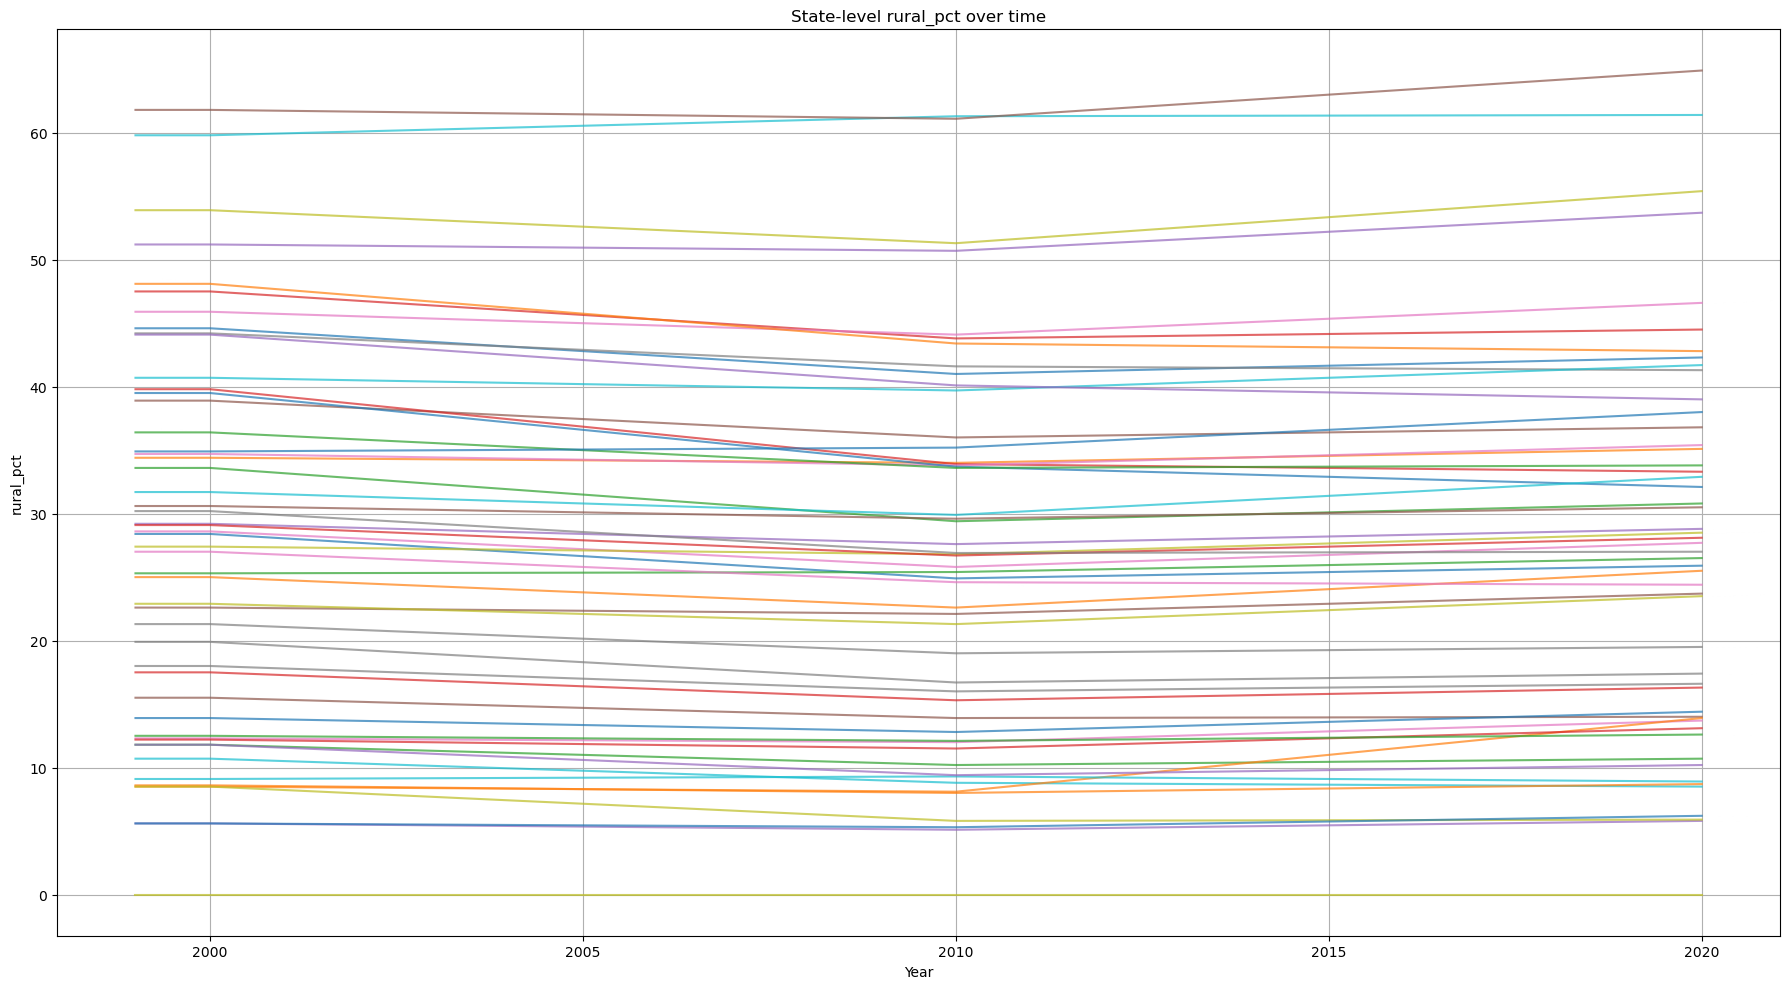

In [134]:
plot_field = "rural_pct"

df_states["year"] = df_states["year"].astype(int)
df_states[plot_field] = pd.to_numeric(df_states[plot_field], errors="coerce")

plot_df = (
    df_states[["state", "year", plot_field]]
    .dropna(subset=[plot_field])
    .drop_duplicates()
    .sort_values(["state", "year"])
)

print(plot_df.head())

plt.figure(figsize=(18, 10))

for state, grp in plot_df.groupby("state"):
    plt.plot(grp["year"], grp[plot_field], label=state, alpha=0.7)

plt.xlabel("Year")
plt.ylabel(plot_field)
plt.title(f"State-level {plot_field} over time")

plt.grid(True)
plt.tight_layout()
plt.show()

In [135]:
df_states.head(5)

year    state  state_code sex age_code  \
0  1999  Alabama         1.0   F        1   
1  1999  Alabama         1.0   F        1   
2  1999  Alabama         1.0   F        1   
3  1999  Alabama         1.0   F        1   
4  1999  Alabama         1.0   F        1   

                                                 UCD      deaths  population  \
0                     #Malignant neoplasms (C00-C97)  Suppressed     28712.0   
1       #Diseases of heart (I00-I09,I11,I13,I20-I51)  Suppressed     28712.0   
2                #Cerebrovascular diseases (I60-I69)           0     28712.0   
3      #Chronic lower respiratory diseases (J40-J47)           0     28712.0   
4  #Accidents (unintentional injuries) (V01-X59,Y...  Suppressed     28712.0   

   obesity_pct  uninsured_pct  seatbelt_always_pct  income_mean  employed_pct  \
0    24.260702      15.065966                  NaN     4.879943     60.490041   
1    24.260702      15.065966                  NaN     4.879943     60.490041   
2    24.260702      15.065966                  NaN     4.879943     60.490041   
3    24.260702      15.065966                  NaN     4.879943     60.490041   
4    24.260702      15.065966                  NaN     4.879943     60.490041   

   diabetes_pct   educa_z  smoking_pct_z  binge_drink_pct_z  \
0      7.377977 -1.626172       0.142507          -0.929252   
1      7.377977 -1.626172       0.142507          -0.929252   
2      7.377977 -1.626172       0.142507          -0.929252   
3      7.377977 -1.626172       0.142507          -0.929252   
4      7.377977 -1.626172       0.142507          -0.929252   

   seatbelt_always_pct_z  rural_pct  
0                    NaN       44.6  
1                    NaN       44.6  
2                    NaN       44.6  
3                    NaN       44.6  
4                    NaN       44.6

In [138]:
df_states.isna().sum()

year                         0
state                        0
state_code                   0
sex                          0
age_code                     0
UCD                          0
deaths                       0
population                   0
obesity_pct                  0
uninsured_pct                0
seatbelt_always_pct      13770
income_mean                  0
employed_pct                 0
diabetes_pct                 0
educa_z                      0
smoking_pct_z                0
binge_drink_pct_z            0
seatbelt_always_pct_z    13770
rural_pct                    0
dtype: int64

         state  year  seatbelt_always_pct_z
13770  Alabama  2002               1.105367
18360  Alabama  2003               0.877494
22950  Alabama  2004               0.687225
27540  Alabama  2005               0.531837
32130  Alabama  2006               0.405333


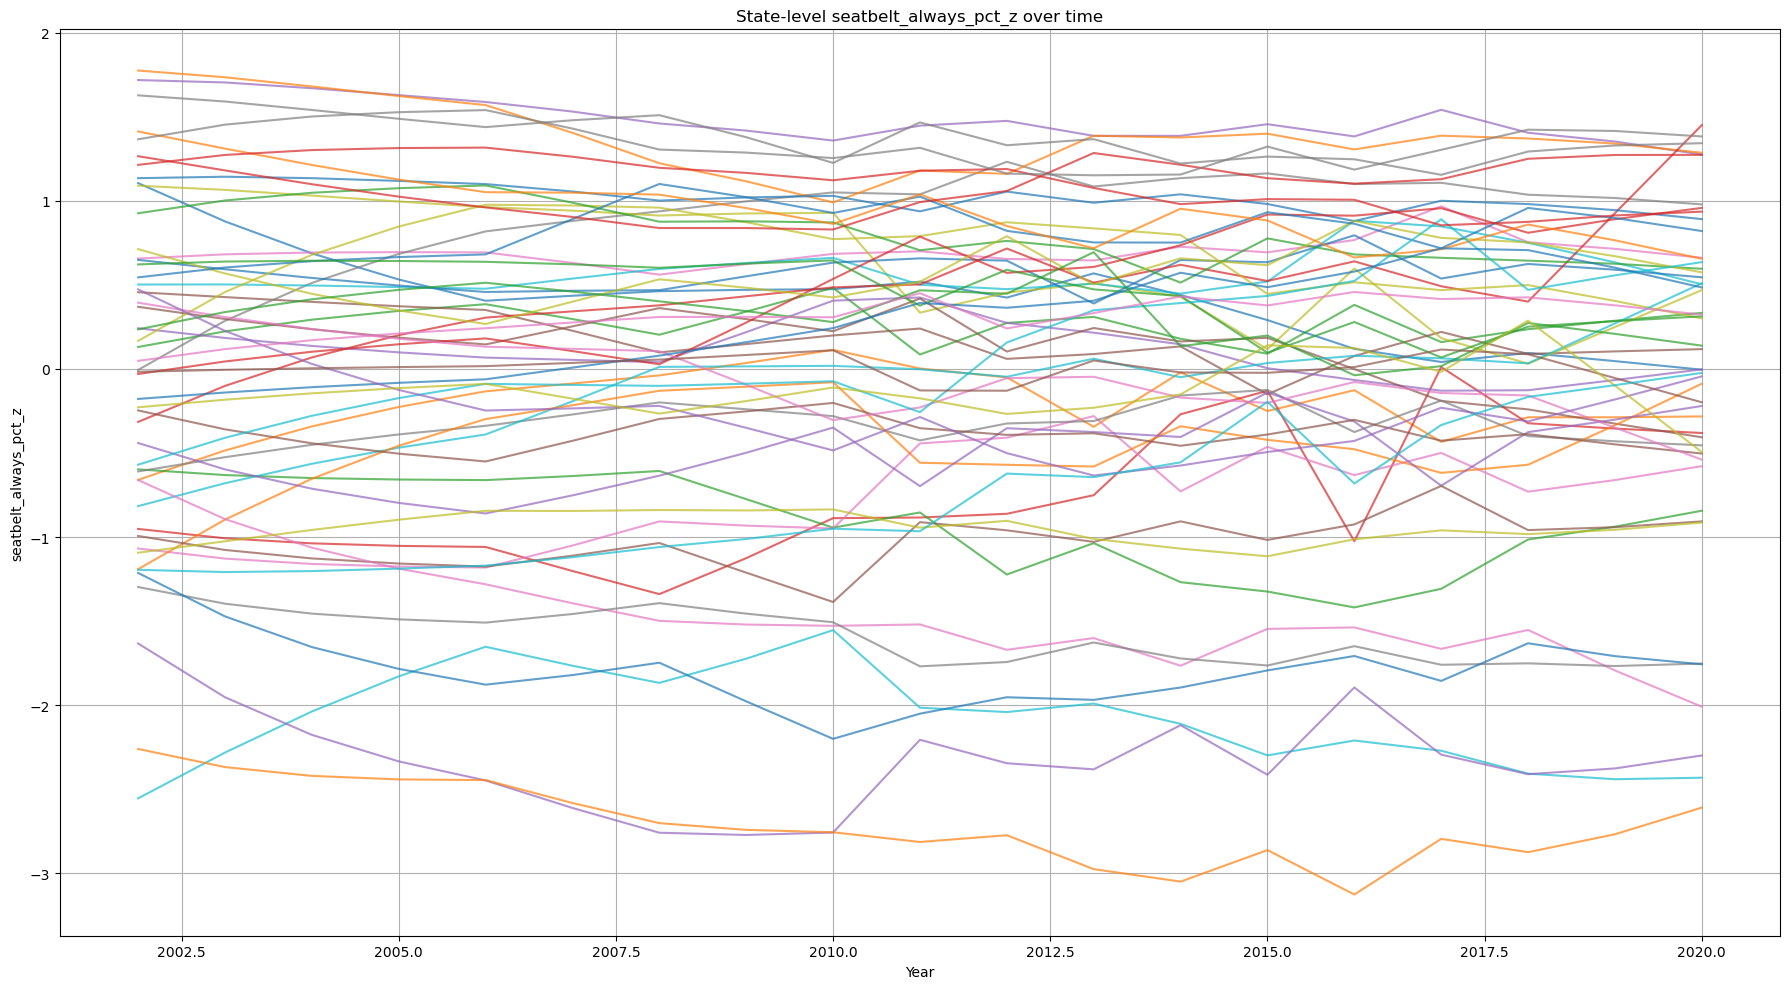

In [139]:
plot_field = "seatbelt_always_pct_z"

df_states["year"] = df_states["year"].astype(int)
df_states[plot_field] = pd.to_numeric(df_states[plot_field], errors="coerce")

plot_df = (
    df_states[["state", "year", plot_field]]
    .dropna(subset=[plot_field])
    .drop_duplicates()
    .sort_values(["state", "year"])
)

print(plot_df.head())

plt.figure(figsize=(18, 10))

for state, grp in plot_df.groupby("state"):
    plt.plot(grp["year"], grp[plot_field], label=state, alpha=0.7)

plt.xlabel("Year")
plt.ylabel(plot_field)
plt.title(f"State-level {plot_field} over time")

plt.grid(True)
plt.tight_layout()
plt.show()

In [140]:
pairs_states = df_states[["state", "year"]].drop_duplicates()
pairs_rf = rf_merge[["state", "year"]].drop_duplicates()

missing_pairs = (
    pairs_states
    .merge(pairs_rf, on=["state", "year"], how="left", indicator=True)
    .query('_merge == "left_only"')
    .drop(columns=["_merge"])
    .sort_values(["state", "year"])
)

missing_pairs

state  year
266       Hawaii  2004
1050  New Jersey  2019

In [141]:
seat = (
    df_states[["state", "year", "seatbelt_always_pct"]]
    .drop_duplicates()
    .sort_values(["state", "year"])
)

rows = []
for state, grp in seat.groupby("state"):
    g = grp.set_index("year")["seatbelt_always_pct"].sort_index()
    
    years_full = np.arange(1999, 2021)
    s_full = g.reindex(years_full)
    
    if s_full.notna().sum() == 0:
        continue
    
    s_interp = s_full.interpolate(method="linear", limit_direction="both")
    
    s_interp = s_interp.clip(0, 100)
    
    for y, val in s_interp.items():
        rows.append({"state": state, "year": int(y), "seatbelt_always_pct_filled": float(val)})

seat_filled = pd.DataFrame(rows)

df_states = df_states.merge(
    seat_filled,
    on=["state", "year"],
    how="left"
)

df_states["seatbelt_always_pct"] = df_states["seatbelt_always_pct"].fillna(
    df_states["seatbelt_always_pct_filled"]
)
df_states = df_states.drop(columns=["seatbelt_always_pct_filled"])

print(df_states["seatbelt_always_pct"].isna().sum())

0


In [142]:
df_states["seatbelt_always_pct_centered"] = (
    df_states["seatbelt_always_pct"]
    - df_states.groupby("year")["seatbelt_always_pct"].transform("mean")
)

# z-score
df_states["seatbelt_always_pct_z"] = (
    df_states["seatbelt_always_pct"]
    - df_states.groupby("year")["seatbelt_always_pct"].transform("mean")
) / df_states.groupby("year")["seatbelt_always_pct"].transform("std")

In [144]:
df_states.isna().sum()

year                            0
state                           0
state_code                      0
sex                             0
age_code                        0
UCD                             0
deaths                          0
population                      0
obesity_pct                     0
uninsured_pct                   0
seatbelt_always_pct             0
income_mean                     0
employed_pct                    0
diabetes_pct                    0
educa_z                         0
smoking_pct_z                   0
binge_drink_pct_z               0
seatbelt_always_pct_z           0
rural_pct                       0
seatbelt_always_pct_centered    0
dtype: int64

         state  year  seatbelt_always_pct_z
0      Alabama  1999               1.105367
4590   Alabama  2000               1.105367
9180   Alabama  2001               1.105367
13770  Alabama  2002               1.105367
18360  Alabama  2003               0.877494


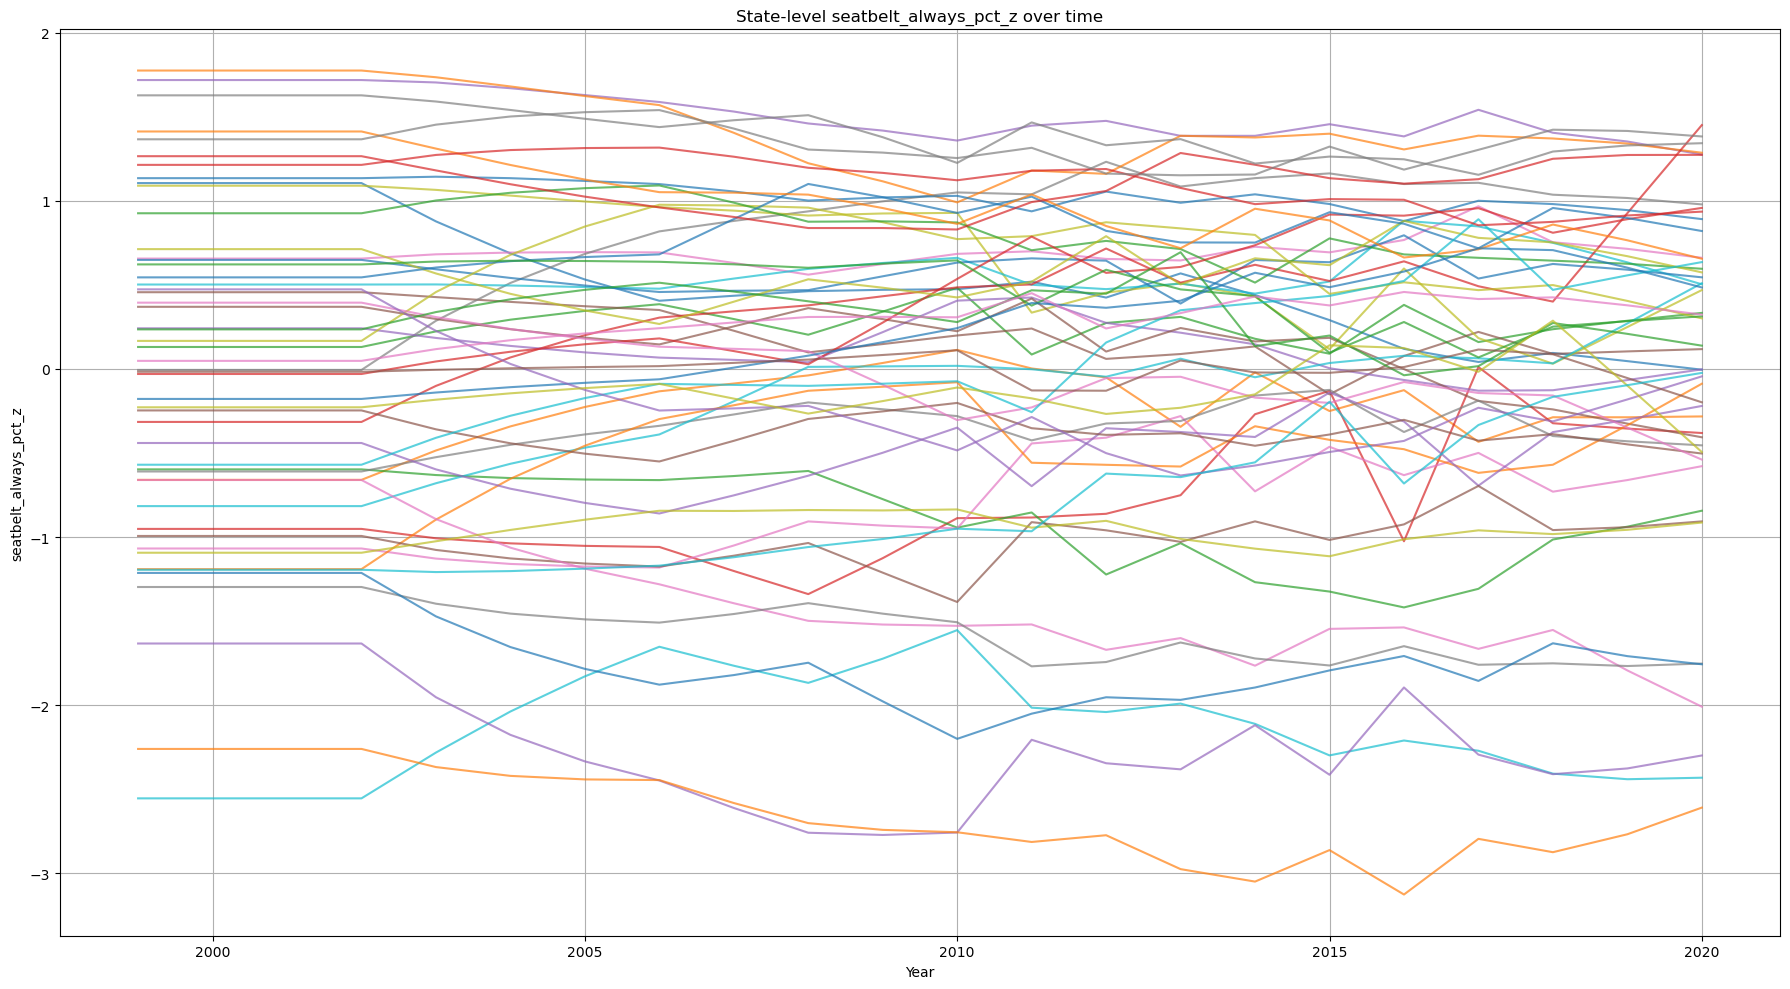

In [145]:
plot_field = "seatbelt_always_pct_z"

df_states["year"] = df_states["year"].astype(int)
df_states[plot_field] = pd.to_numeric(df_states[plot_field], errors="coerce")

plot_df = (
    df_states[["state", "year", plot_field]]
    .dropna(subset=[plot_field])
    .drop_duplicates()
    .sort_values(["state", "year"])
)

print(plot_df.head())

plt.figure(figsize=(18, 10))

for state, grp in plot_df.groupby("state"):
    plt.plot(grp["year"], grp[plot_field], label=state, alpha=0.7)

plt.xlabel("Year")
plt.ylabel(plot_field)
plt.title(f"State-level {plot_field} over time")

plt.grid(True)
plt.tight_layout()
plt.show()

In [148]:
df_states.drop(columns = {'seatbelt_always_pct_centered','seatbelt_always_pct'},inplace=True)

In [154]:
df_states = pd.read_csv('/Users/ryan/OMSA/3.Fall2025/CSE6242/Project/df_states.csv')
df_test['age_code'].unique()

array(['1', '1-4', '5-14', '15-24', '25-34', '35-44', '45-54', '55-64',
       '65-74'], dtype=object)

# Export csv df_states

In [149]:
out_path = "/Users/ryan/OMSA/3.Fall2025/CSE6242/Project/df_states.csv"
df_states.to_csv(out_path, index=False)

### Model

In [15]:
#### MUST FIX IF YOU END UP CHANGING THE SAVED DF_STATES, ABOVE EXPORT SAVES CSV TO DIFFERENT LOCATION
df_states= pd.read_csv('/Users/ryan/OMSA/3.Fall2025/CSE6242/Project/data/df_states.csv')

In [16]:
model_path = "/Users/ryan/OMSA/3.Fall2025/CSE6242/Project/streamlit/LongerTomorrow/model/model.pkl"

with open(model_path, "rb") as f:
    model = pickle.load(f)

In [17]:
FEATURE_COLS = [
    "year",
    "state",
    "sex",
    "UCD",
    "years_from_start",
    "obesity_pct",
    "uninsured_pct",
    "income_mean",
    "employed_pct",
    "diabetes_pct",
    "educa_z",
    "smoking_pct_z",
    "binge_drink_pct_z",
    "seatbelt_always_pct_z",
    "rural_pct",
]

In [18]:
df = df_states.copy()

df["years_from_start"] = df["year"] - df["year"].min()

for col in ["state", "sex", "UCD"]:
    df[col] = df[col].astype("category")

missing = [c for c in FEATURE_COLS if c not in df.columns]
missing

[]

#### Model Setup

this section is where I'll prototype what I expect to do in the Streamlit app. I just want to make sure that I can feed inputs into the model and retrieve predictions (mimic the slider inputs).

In [19]:
X = df[FEATURE_COLS]
y_pred = model.predict(X)

df["ypll_pred"] = y_pred
df[["state", "year", "UCD", "ypll_pred"]].head()

state  year                                                UCD  ypll_pred
0  Alabama  1999                     #Malignant neoplasms (C00-C97)  190.10007
1  Alabama  1999       #Diseases of heart (I00-I09,I11,I13,I20-I51)  190.10007
2  Alabama  1999                #Cerebrovascular diseases (I60-I69)  190.10007
3  Alabama  1999      #Chronic lower respiratory diseases (J40-J47)  190.10007
4  Alabama  1999  #Accidents (unintentional injuries) (V01-X59,Y...  190.10007

In [20]:
UCD_MAP = {
    '#Malignant neoplasms (C00-C97)': 'cancer',
    '#Diseases of heart (I00-I09,I11,I13,I20-I51)': 'heart_disease',
    '#Cerebrovascular diseases (I60-I69)': 'stroke',
    '#Chronic lower respiratory diseases (J40-J47)': 'lower_resp',
    '#Accidents (unintentional injuries) (V01-X59,Y85-Y86)': 'accidents',
}

#### EXAMPLE MODEL INPUTS FROM UI
improvements = {
    "cancer": 10,
    "heart_disease": 0,
    "stroke": 5,
    "accidents": 20,
}

df["cause_short"] = df["UCD"].map(UCD_MAP)
factors_by_cause = {k: 1 - v/100.0 for k, v in improvements.items()}
df["factor"] = df["cause_short"].map(factors_by_cause).fillna(1.0)
df["ypll_adj"] = df["ypll_pred"] * df["factor"]

In [21]:
start_year = df["year"].min()
df["years_from_start"] = df["year"] - start_year

for col in ["state", "sex", "UCD"]:
    df[col] = df[col].astype("category")

base_year = df["year"].max()
d = df[df["year"] == base_year].copy()

target_year = 2030
d["year"] = target_year
d["years_from_start"] = target_year - start_year

X_2030 = d[FEATURE_COLS]
d["ypll_pred_2030"] = model.predict(X_2030)

In [22]:
d["cause_short"] = d["UCD"].map(UCD_MAP)
factors_by_cause = {k: 1 - v/100.0 for k, v in improvements.items()}

d["factor"] = d["cause_short"].map(factors_by_cause).fillna(1.0)
d["ypll_adj_2030"] = d["ypll_pred_2030"] * d["factor"]

In [23]:
summary_2030 = (
    d.groupby("state", as_index=False)
     .agg(
         baseline_2030=("ypll_pred_2030", "sum"),
         adjusted_2030=("ypll_adj_2030", "sum"),
     )
)

summary_2030["savings_2030"] = (
    summary_2030["baseline_2030"] - summary_2030["adjusted_2030"]
)

/var/folders/fm/_6kg8xkn3jz4slz27zwpqnhc0000gn/T/ipykernel_28778/1810866723.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [24]:
STATE_ABBREV = {
    "Alabama": "AL", "Alaska": "AK", "Arizona": "AZ", "Arkansas": "AR",
    "California": "CA", "Colorado": "CO", "Connecticut": "CT", "Delaware": "DE",
    "District of Columbia": "DC", "Florida": "FL", "Georgia": "GA", "Hawaii": "HI",
    "Idaho": "ID", "Illinois": "IL", "Indiana": "IN", "Iowa": "IA",
    "Kansas": "KS", "Kentucky": "KY", "Louisiana": "LA", "Maine": "ME",
    "Maryland": "MD", "Massachusetts": "MA", "Michigan": "MI", "Minnesota": "MN",
    "Mississippi": "MS", "Missouri": "MO", "Montana": "MT", "Nebraska": "NE",
    "Nevada": "NV", "New Hampshire": "NH", "New Jersey": "NJ", "New Mexico": "NM",
    "New York": "NY", "North Carolina": "NC", "North Dakota": "ND", "Ohio": "OH",
    "Oklahoma": "OK", "Oregon": "OR", "Pennsylvania": "PA", "Rhode Island": "RI",
    "South Carolina": "SC", "South Dakota": "SD", "Tennessee": "TN", "Texas": "TX",
    "Utah": "UT", "Vermont": "VT", "Virginia": "VA", "Washington": "WA",
    "West Virginia": "WV", "Wisconsin": "WI", "Wyoming": "WY",
}

In [25]:
summary_2030["state_abbrev"] = summary_2030["state"].map(STATE_ABBREV)

fig = px.choropleth(
    summary_2030.dropna(subset=["state_abbrev"]),
    locations="state_abbrev",
    locationmode="USA-states",
    color="savings_2030",
    scope="usa",
    color_continuous_scale="Viridis",
    labels={"savings_2030": "YPLL saved in 2030"},
    hover_name="state",
    hover_data={
        "baseline_2030": ":,.0f",
        "adjusted_2030": ":,.0f",
        "savings_2030": ":,.0f",
        "state_abbrev": False,
    },
)

fig.update_layout(
    title="Projected YPLL savings in 2030 under slider scenario",
    margin=dict(l=0, r=0, t=40, b=0),
)

fig.show()

In [26]:
df

year    state  state_code sex age_code  \
0       1999  Alabama         1.0   F        1   
1       1999  Alabama         1.0   F        1   
2       1999  Alabama         1.0   F        1   
3       1999  Alabama         1.0   F        1   
4       1999  Alabama         1.0   F        1   
...      ...      ...         ...  ..      ...   
100975  2020  Wyoming        56.0   M    65-74   
100976  2020  Wyoming        56.0   M    65-74   
100977  2020  Wyoming        56.0   M    65-74   
100978  2020  Wyoming        56.0   M    65-74   
100979  2020  Wyoming        56.0   M    65-74   

                                                      UCD      deaths  \
0                          #Malignant neoplasms (C00-C97)  Suppressed   
1            #Diseases of heart (I00-I09,I11,I13,I20-I51)  Suppressed   
2                     #Cerebrovascular diseases (I60-I69)           0   
3           #Chronic lower respiratory diseases (J40-J47)           0   
4       #Accidents (unintentional injuries) (V01-X59,Y...  Suppressed   
...                                                   ...         ...   
100975                     #Malignant neoplasms (C00-C97)         188   
100976       #Diseases of heart (I00-I09,I11,I13,I20-I51)         186   
100977                #Cerebrovascular diseases (I60-I69)          21   
100978      #Chronic lower respiratory diseases (J40-J47)          64   
100979  #Accidents (unintentional injuries) (V01-X59,Y...          24   

        population  obesity_pct  uninsured_pct  ...   educa_z  smoking_pct_z  \
0          28712.0    24.260702      15.065966  ... -1.626172       0.142507   
1          28712.0    24.260702      15.065966  ... -1.626172       0.142507   
2          28712.0    24.260702      15.065966  ... -1.626172       0.142507   
3          28712.0    24.260702      15.065966  ... -1.626172       0.142507   
4          28712.0    24.260702      15.065966  ... -1.626172       0.142507   
...            ...          ...            ...  ...       ...            ...   
100975     32197.0    30.700000      18.535808  ...  0.311704       0.957473   
100976     32197.0    30.700000      18.535808  ...  0.311704       0.957473   
100977     32197.0    30.700000      18.535808  ...  0.311704       0.957473   
100978     32197.0    30.700000      18.535808  ...  0.311704       0.957473   
100979     32197.0    30.700000      18.535808  ...  0.311704       0.957473   

        binge_drink_pct_z  seatbelt_always_pct_z  rural_pct  years_from_start  \
0               -0.929252               1.105367       44.6                 0   
1               -0.929252               1.105367       44.6                 0   
2               -0.929252               1.105367       44.6                 0   
3               -0.929252               1.105367       44.6                 0   
4               -0.929252               1.105367       44.6                 0   
...                   ...                    ...        ...               ...   
100975           0.154162              -1.757050       38.0                21   
100976           0.154162              -1.757050       38.0                21   
100977           0.154162              -1.757050       38.0                21   
100978           0.154162              -1.757050       38.0                21   
100979           0.154162              -1.757050       38.0                21   

        ypll_pred    cause_short  factor    ypll_adj  
0       190.10007         cancer    0.90  171.090063  
1       190.10007  heart_disease    1.00  190.100070  
2       190.10007         stroke    0.95  180.595066  
3       190.10007     lower_resp    1.00  190.100070  
4       190.10007      accidents    0.80  152.080056  
...           ...            ...     ...         ...  
100975  105.62876         cancer    0.90   95.065884  
100976  105.62876  heart_disease    1.00  105.628760  
100977  105.62876         stroke    0.95  100.347322  
100978  105.62876     lower_resp    1.00  105.

-----

This is the end of the UCD file. The remaining actions are completed in the modeling file and in the UI (app.py)

-----